# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('kfold_res_aug_nodp_1e-5')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 34.7 s, sys: 30.4 s, total: 1min 5s
Wall time: 6.92 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

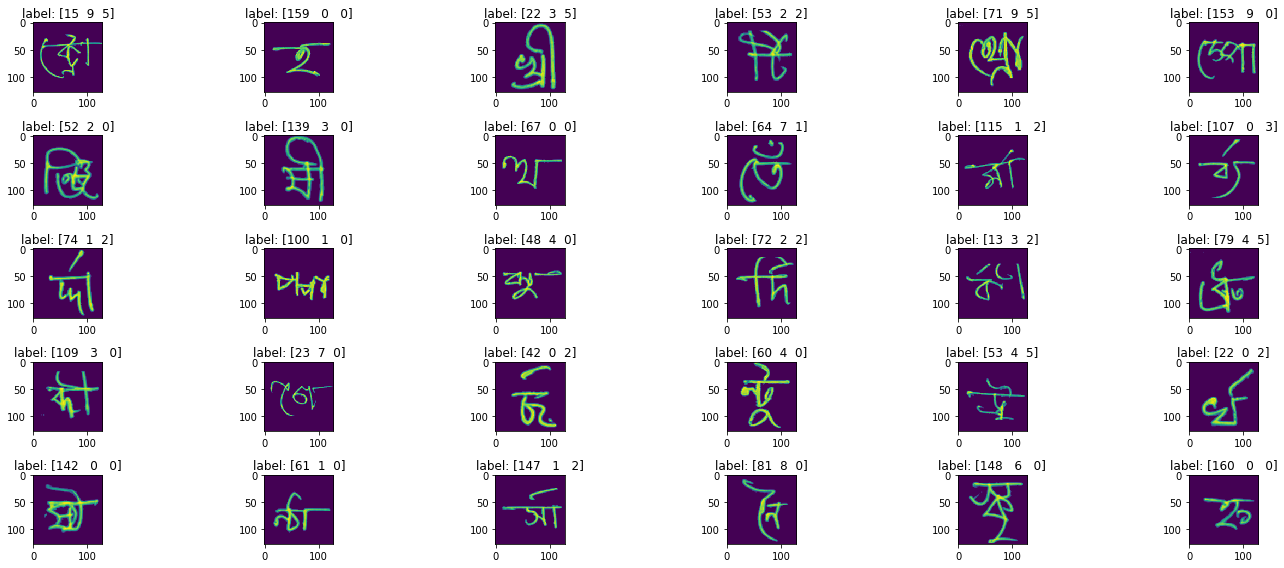

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

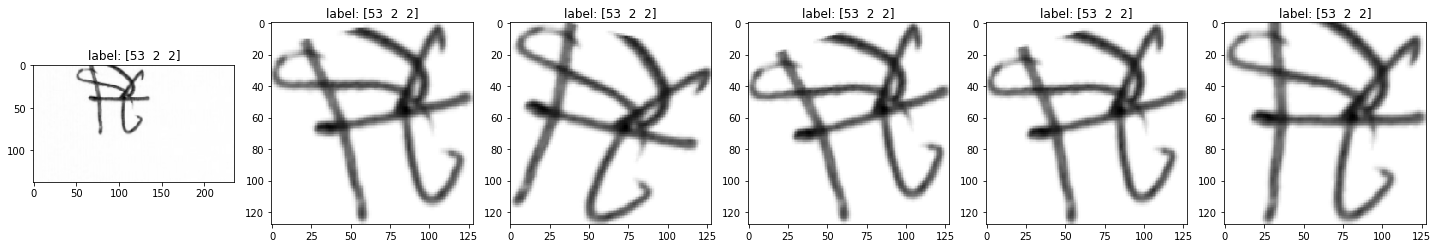

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

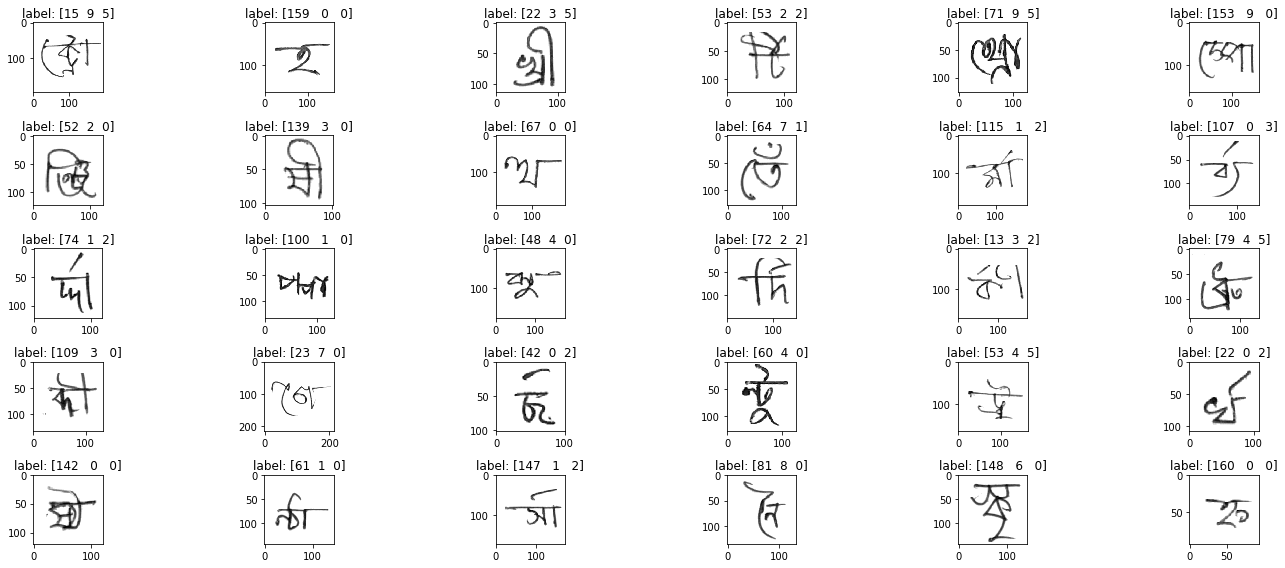

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

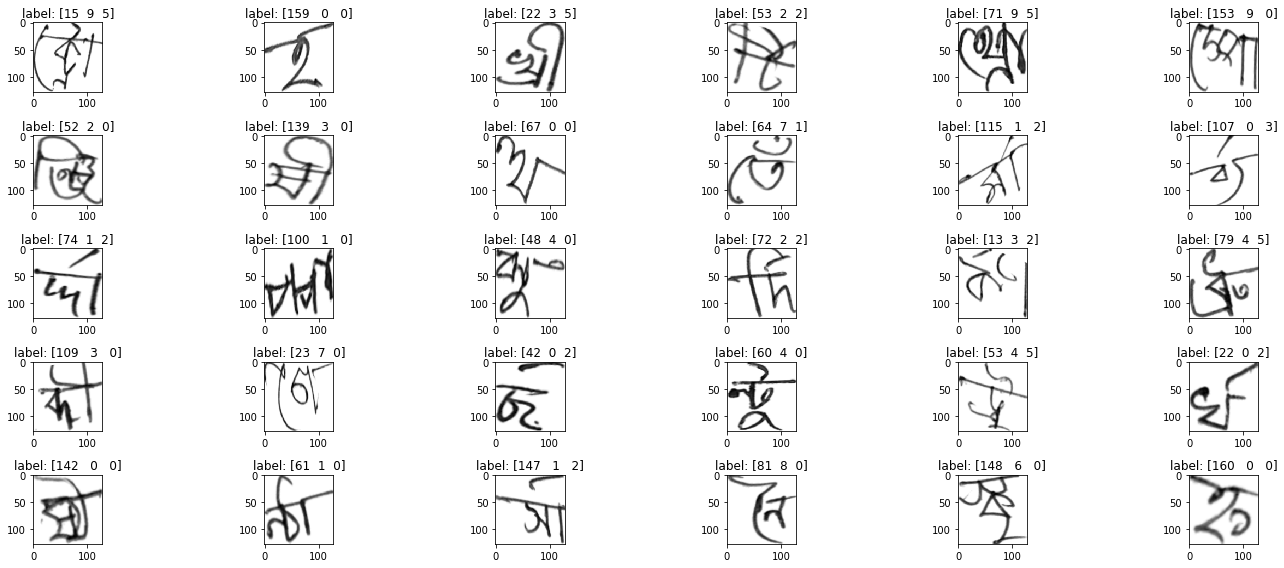

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

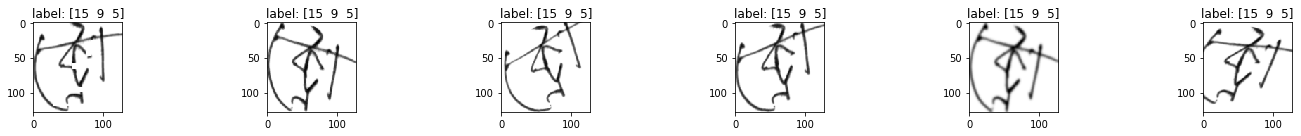

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

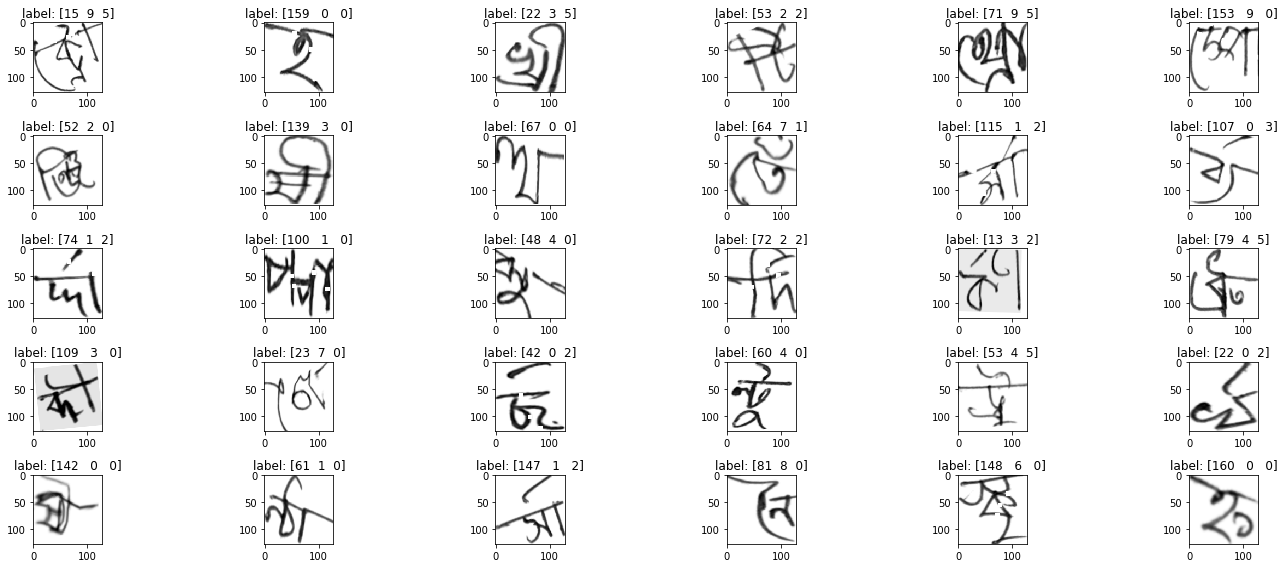

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [42]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [47]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 4
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.002, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  3.319083 train/loss_grapheme  2.124200 train/loss_vowel  0.636084 train/loss_consonant  0.558799 train/acc_grapheme  0.534430 train/acc_vowel  0.831713 train/acc_consonant  0.856521 train/recall  0.602492 val/loss  0.851288 val/loss_grapheme  0.529797 val/loss_vowel  0.153179 val/loss_consonant  0.168312 val/acc_grapheme  0.864768 val/acc_vowel  0.963454 val/acc_consonant  0.955512 val/recall  0.866244 lr  0.002000 elapsed_time  620.543282 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  0.975317 train/loss_grapheme  0.610783 train/loss_vowel  0.190947 train/loss_consonant  0.173587 train/acc_grapheme  0.843980 train/acc_vowel  0.948137 train/acc_consonant  0.950346 train/recall  0.845452 val/loss  0.558273 val/loss_grapheme  0.339831 val/loss_vowel  0.112577 val/loss_consonant  0.105865 val/acc_grapheme  0.907489 val/acc_vowel  0.970872 val/acc_consonant  0.971022 val/recall  0.902133 lr  0.002000 elapsed_time  1235.998557 mode 011 


100%|██████████| 419/419 [01:06<00:00,  6.32it/s]


epoch      2 train/loss  0.763944 train/loss_grapheme  0.473174 train/loss_vowel  0.151508 train/loss_consonant  0.139262 train/acc_grapheme  0.875349 train/acc_vowel  0.958537 train/acc_consonant  0.958686 train/recall  0.874120 val/loss  0.494183 val/loss_grapheme  0.303865 val/loss_vowel  0.095356 val/loss_consonant  0.094962 val/acc_grapheme  0.917347 val/acc_vowel  0.974233 val/acc_consonant  0.972092 val/recall  0.915300 lr  0.002000 elapsed_time  1847.732546 mode 011 


100%|██████████| 419/419 [01:05<00:00,  6.36it/s]


epoch      3 train/loss  0.666192 train/loss_grapheme  0.408855 train/loss_vowel  0.135427 train/loss_consonant  0.121910 train/acc_grapheme  0.890883 train/acc_vowel  0.962196 train/acc_consonant  0.963373 train/recall  0.888835 val/loss  0.425436 val/loss_grapheme  0.265263 val/loss_vowel  0.081162 val/loss_consonant  0.079010 val/acc_grapheme  0.928301 val/acc_vowel  0.978416 val/acc_consonant  0.977196 val/recall  0.926083 lr  0.002000 elapsed_time  2466.215890 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.597420 train/loss_grapheme  0.366039 train/loss_vowel  0.121601 train/loss_consonant  0.109780 train/acc_grapheme  0.900381 train/acc_vowel  0.965931 train/acc_consonant  0.966671 train/recall  0.897447 val/loss  0.418135 val/loss_grapheme  0.257948 val/loss_vowel  0.082954 val/loss_consonant  0.077233 val/acc_grapheme  0.930392 val/acc_vowel  0.977644 val/acc_consonant  0.977644 val/recall  0.927031 lr  0.002000 elapsed_time  3088.610812 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.555296 train/loss_grapheme  0.337367 train/loss_vowel  0.113762 train/loss_consonant  0.104167 train/acc_grapheme  0.908578 train/acc_vowel  0.968209 train/acc_consonant  0.968414 train/recall  0.905406 val/loss  0.392762 val/loss_grapheme  0.242839 val/loss_vowel  0.072186 val/loss_consonant  0.077737 val/acc_grapheme  0.934127 val/acc_vowel  0.980855 val/acc_consonant  0.977918 val/recall  0.929926 lr  0.002000 elapsed_time  3702.797703 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.523147 train/loss_grapheme  0.315423 train/loss_vowel  0.108580 train/loss_consonant  0.099143 train/acc_grapheme  0.913681 train/acc_vowel  0.969366 train/acc_consonant  0.969908 train/recall  0.910121 val/loss  0.371052 val/loss_grapheme  0.225345 val/loss_vowel  0.073380 val/loss_consonant  0.072328 val/acc_grapheme  0.938434 val/acc_vowel  0.980582 val/acc_consonant  0.979038 val/recall  0.935324 lr  0.002000 elapsed_time  4317.185217 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.489718 train/loss_grapheme  0.297187 train/loss_vowel  0.100809 train/loss_consonant  0.091722 train/acc_grapheme  0.917926 train/acc_vowel  0.971401 train/acc_consonant  0.972472 train/recall  0.914468 val/loss  0.397557 val/loss_grapheme  0.235870 val/loss_vowel  0.078944 val/loss_consonant  0.082742 val/acc_grapheme  0.936865 val/acc_vowel  0.978142 val/acc_consonant  0.976349 val/recall  0.931612 lr  0.002000 elapsed_time  4927.782647 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.467188 train/loss_grapheme  0.283287 train/loss_vowel  0.095481 train/loss_consonant  0.088419 train/acc_grapheme  0.921200 train/acc_vowel  0.973225 train/acc_consonant  0.973318 train/recall  0.917923 val/loss  0.403775 val/loss_grapheme  0.249134 val/loss_vowel  0.080022 val/loss_consonant  0.074618 val/acc_grapheme  0.930766 val/acc_vowel  0.977743 val/acc_consonant  0.977843 val/recall  0.930006 lr  0.002000 elapsed_time  5533.482996 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.449963 train/loss_grapheme  0.269293 train/loss_vowel  0.094426 train/loss_consonant  0.086244 train/acc_grapheme  0.924100 train/acc_vowel  0.973144 train/acc_consonant  0.974028 train/recall  0.920236 val/loss  0.378034 val/loss_grapheme  0.230315 val/loss_vowel  0.079491 val/loss_consonant  0.068228 val/acc_grapheme  0.938110 val/acc_vowel  0.978067 val/acc_consonant  0.980258 val/recall  0.933076 lr  0.002000 elapsed_time  6143.846411 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.435130 train/loss_grapheme  0.259926 train/loss_vowel  0.090936 train/loss_consonant  0.084268 train/acc_grapheme  0.926764 train/acc_vowel  0.974681 train/acc_consonant  0.974495 train/recall  0.922375 val/loss  0.341977 val/loss_grapheme  0.215485 val/loss_vowel  0.064235 val/loss_consonant  0.062257 val/acc_grapheme  0.941894 val/acc_vowel  0.982872 val/acc_consonant  0.982250 val/recall  0.939386 lr  0.002000 elapsed_time  6757.600554 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.418165 train/loss_grapheme  0.251264 train/loss_vowel  0.086671 train/loss_consonant  0.080231 train/acc_grapheme  0.929415 train/acc_vowel  0.975571 train/acc_consonant  0.975677 train/recall  0.925608 val/loss  0.330551 val/loss_grapheme  0.199976 val/loss_vowel  0.064752 val/loss_consonant  0.065824 val/acc_grapheme  0.944209 val/acc_vowel  0.982822 val/acc_consonant  0.980631 val/recall  0.941320 lr  0.002000 elapsed_time  7367.672998 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.409848 train/loss_grapheme  0.245585 train/loss_vowel  0.085821 train/loss_consonant  0.078442 train/acc_grapheme  0.929957 train/acc_vowel  0.975472 train/acc_consonant  0.975970 train/recall  0.926778 val/loss  0.340913 val/loss_grapheme  0.204165 val/loss_vowel  0.068572 val/loss_consonant  0.068176 val/acc_grapheme  0.944732 val/acc_vowel  0.982200 val/acc_consonant  0.980606 val/recall  0.938993 lr  0.002000 elapsed_time  7970.176954 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.32it/s]


epoch     13 train/loss  0.399037 train/loss_grapheme  0.239892 train/loss_vowel  0.082460 train/loss_consonant  0.076685 train/acc_grapheme  0.932228 train/acc_vowel  0.976511 train/acc_consonant  0.976773 train/recall  0.928779 val/loss  0.359398 val/loss_grapheme  0.224547 val/loss_vowel  0.069935 val/loss_consonant  0.064915 val/acc_grapheme  0.937662 val/acc_vowel  0.981204 val/acc_consonant  0.980806 val/recall  0.935375 lr  0.002000 elapsed_time  8578.697350 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.393072 train/loss_grapheme  0.235921 train/loss_vowel  0.081713 train/loss_consonant  0.075437 train/acc_grapheme  0.932409 train/acc_vowel  0.976717 train/acc_consonant  0.976841 train/recall  0.928768 val/loss  0.326164 val/loss_grapheme  0.199149 val/loss_vowel  0.065227 val/loss_consonant  0.061788 val/acc_grapheme  0.944533 val/acc_vowel  0.983196 val/acc_consonant  0.982299 val/recall  0.941666 lr  0.002000 elapsed_time  9187.965489 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.382171 train/loss_grapheme  0.227355 train/loss_vowel  0.080139 train/loss_consonant  0.074677 train/acc_grapheme  0.934712 train/acc_vowel  0.976816 train/acc_consonant  0.977619 train/recall  0.930413 val/loss  0.339005 val/loss_grapheme  0.206108 val/loss_vowel  0.067025 val/loss_consonant  0.065873 val/acc_grapheme  0.944807 val/acc_vowel  0.982100 val/acc_consonant  0.981328 val/recall  0.941848 lr  0.002000 elapsed_time  9793.264723 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.375752 train/loss_grapheme  0.223475 train/loss_vowel  0.079194 train/loss_consonant  0.073084 train/acc_grapheme  0.935975 train/acc_vowel  0.977607 train/acc_consonant  0.977887 train/recall  0.931651 val/loss  0.349301 val/loss_grapheme  0.215143 val/loss_vowel  0.063569 val/loss_consonant  0.070589 val/acc_grapheme  0.941247 val/acc_vowel  0.983121 val/acc_consonant  0.979860 val/recall  0.937056 lr  0.002000 elapsed_time  10398.220174 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.367803 train/loss_grapheme  0.219566 train/loss_vowel  0.077368 train/loss_consonant  0.070870 train/acc_grapheme  0.937046 train/acc_vowel  0.977880 train/acc_consonant  0.977918 train/recall  0.932669 val/loss  0.326514 val/loss_grapheme  0.198723 val/loss_vowel  0.065940 val/loss_consonant  0.061850 val/acc_grapheme  0.944433 val/acc_vowel  0.982374 val/acc_consonant  0.982125 val/recall  0.940971 lr  0.002000 elapsed_time  11006.505406 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.361278 train/loss_grapheme  0.213899 train/loss_vowel  0.076837 train/loss_consonant  0.070542 train/acc_grapheme  0.938515 train/acc_vowel  0.978273 train/acc_consonant  0.978055 train/recall  0.934011 val/loss  0.318411 val/loss_grapheme  0.195635 val/loss_vowel  0.062385 val/loss_consonant  0.060391 val/acc_grapheme  0.946500 val/acc_vowel  0.983494 val/acc_consonant  0.981876 val/recall  0.943025 lr  0.002000 elapsed_time  11612.023886 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.360259 train/loss_grapheme  0.214263 train/loss_vowel  0.076100 train/loss_consonant  0.069895 train/acc_grapheme  0.937849 train/acc_vowel  0.978870 train/acc_consonant  0.978690 train/recall  0.934285 val/loss  0.318381 val/loss_grapheme  0.197675 val/loss_vowel  0.059756 val/loss_consonant  0.060951 val/acc_grapheme  0.946848 val/acc_vowel  0.984540 val/acc_consonant  0.982299 val/recall  0.943712 lr  0.002000 elapsed_time  12217.552236 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.359274 train/loss_grapheme  0.212031 train/loss_vowel  0.077042 train/loss_consonant  0.070202 train/acc_grapheme  0.938932 train/acc_vowel  0.978036 train/acc_consonant  0.978758 train/recall  0.934462 val/loss  0.317843 val/loss_grapheme  0.195515 val/loss_vowel  0.063666 val/loss_consonant  0.058662 val/acc_grapheme  0.946276 val/acc_vowel  0.983370 val/acc_consonant  0.983494 val/recall  0.943412 lr  0.002000 elapsed_time  12827.032951 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.348960 train/loss_grapheme  0.206639 train/loss_vowel  0.074126 train/loss_consonant  0.068195 train/acc_grapheme  0.939915 train/acc_vowel  0.978914 train/acc_consonant  0.979399 train/recall  0.936070 val/loss  0.325692 val/loss_grapheme  0.197635 val/loss_vowel  0.067129 val/loss_consonant  0.060928 val/acc_grapheme  0.946475 val/acc_vowel  0.982050 val/acc_consonant  0.982274 val/recall  0.942076 lr  0.002000 elapsed_time  13435.384623 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.340254 train/loss_grapheme  0.202250 train/loss_vowel  0.071532 train/loss_consonant  0.066472 train/acc_grapheme  0.941004 train/acc_vowel  0.979492 train/acc_consonant  0.979685 train/recall  0.937335 val/loss  0.322607 val/loss_grapheme  0.195423 val/loss_vowel  0.067551 val/loss_consonant  0.059633 val/acc_grapheme  0.946774 val/acc_vowel  0.982001 val/acc_consonant  0.983096 val/recall  0.942002 lr  0.002000 elapsed_time  14044.452705 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.342983 train/loss_grapheme  0.203078 train/loss_vowel  0.071221 train/loss_consonant  0.068683 train/acc_grapheme  0.941135 train/acc_vowel  0.979791 train/acc_consonant  0.978901 train/recall  0.936979 val/loss  0.335053 val/loss_grapheme  0.207004 val/loss_vowel  0.068507 val/loss_consonant  0.059543 val/acc_grapheme  0.944110 val/acc_vowel  0.981279 val/acc_consonant  0.983196 val/recall  0.941356 lr  0.002000 elapsed_time  14650.850592 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.340120 train/loss_grapheme  0.201074 train/loss_vowel  0.071941 train/loss_consonant  0.067106 train/acc_grapheme  0.941552 train/acc_vowel  0.979051 train/acc_consonant  0.979760 train/recall  0.937390 val/loss  0.307217 val/loss_grapheme  0.189349 val/loss_vowel  0.060500 val/loss_consonant  0.057368 val/acc_grapheme  0.947570 val/acc_vowel  0.983469 val/acc_consonant  0.983967 val/recall  0.943931 lr  0.002000 elapsed_time  15259.056039 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.335340 train/loss_grapheme  0.196704 train/loss_vowel  0.072010 train/loss_consonant  0.066626 train/acc_grapheme  0.942479 train/acc_vowel  0.979667 train/acc_consonant  0.979673 train/recall  0.938922 val/loss  0.316153 val/loss_grapheme  0.191233 val/loss_vowel  0.063132 val/loss_consonant  0.061788 val/acc_grapheme  0.947271 val/acc_vowel  0.983544 val/acc_consonant  0.982150 val/recall  0.943756 lr  0.002000 elapsed_time  15864.089787 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.334982 train/loss_grapheme  0.197323 train/loss_vowel  0.071674 train/loss_consonant  0.065986 train/acc_grapheme  0.942429 train/acc_vowel  0.979679 train/acc_consonant  0.979878 train/recall  0.938491 val/loss  0.312020 val/loss_grapheme  0.190296 val/loss_vowel  0.063928 val/loss_consonant  0.057795 val/acc_grapheme  0.947620 val/acc_vowel  0.983245 val/acc_consonant  0.983918 val/recall  0.944442 lr  0.002000 elapsed_time  16470.978609 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.330124 train/loss_grapheme  0.194760 train/loss_vowel  0.069504 train/loss_consonant  0.065861 train/acc_grapheme  0.942423 train/acc_vowel  0.980245 train/acc_consonant  0.980115 train/recall  0.938665 val/loss  0.317525 val/loss_grapheme  0.196345 val/loss_vowel  0.060991 val/loss_consonant  0.060189 val/acc_grapheme  0.945155 val/acc_vowel  0.984092 val/acc_consonant  0.982573 val/recall  0.943538 lr  0.002000 elapsed_time  17074.110189 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.34it/s]


epoch     28 train/loss  0.322996 train/loss_grapheme  0.192494 train/loss_vowel  0.067474 train/loss_consonant  0.063028 train/acc_grapheme  0.943245 train/acc_vowel  0.980476 train/acc_consonant  0.980227 train/recall  0.939238 val/loss  0.305569 val/loss_grapheme  0.184707 val/loss_vowel  0.060345 val/loss_consonant  0.060516 val/acc_grapheme  0.950209 val/acc_vowel  0.984490 val/acc_consonant  0.982299 val/recall  0.946680 lr  0.002000 elapsed_time  17678.179704 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.323295 train/loss_grapheme  0.190668 train/loss_vowel  0.068970 train/loss_consonant  0.063656 train/acc_grapheme  0.943836 train/acc_vowel  0.980451 train/acc_consonant  0.980314 train/recall  0.940071 val/loss  0.321737 val/loss_grapheme  0.197838 val/loss_vowel  0.062651 val/loss_consonant  0.061249 val/acc_grapheme  0.945454 val/acc_vowel  0.984191 val/acc_consonant  0.982200 val/recall  0.941125 lr  0.002000 elapsed_time  18285.531349 mode 100 


100%|██████████| 419/419 [01:06<00:00,  6.31it/s]


epoch     30 train/loss  0.321833 train/loss_grapheme  0.189328 train/loss_vowel  0.068580 train/loss_consonant  0.063925 train/acc_grapheme  0.944371 train/acc_vowel  0.980326 train/acc_consonant  0.980638 train/recall  0.939434 val/loss  0.318314 val/loss_grapheme  0.194541 val/loss_vowel  0.061869 val/loss_consonant  0.061903 val/acc_grapheme  0.946475 val/acc_vowel  0.984615 val/acc_consonant  0.982026 val/recall  0.943735 lr  0.002000 elapsed_time  18891.364093 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.325581 train/loss_grapheme  0.192548 train/loss_vowel  0.069140 train/loss_consonant  0.063893 train/acc_grapheme  0.943687 train/acc_vowel  0.980177 train/acc_consonant  0.980706 train/recall  0.939717 val/loss  0.315175 val/loss_grapheme  0.192419 val/loss_vowel  0.060853 val/loss_consonant  0.061903 val/acc_grapheme  0.946823 val/acc_vowel  0.984117 val/acc_consonant  0.982001 val/recall  0.944790 lr  0.002000 elapsed_time  19498.118759 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.318883 train/loss_grapheme  0.188061 train/loss_vowel  0.068297 train/loss_consonant  0.062526 train/acc_grapheme  0.944938 train/acc_vowel  0.980470 train/acc_consonant  0.980712 train/recall  0.940157 val/loss  0.304704 val/loss_grapheme  0.183860 val/loss_vowel  0.061052 val/loss_consonant  0.059792 val/acc_grapheme  0.950284 val/acc_vowel  0.983893 val/acc_consonant  0.983494 val/recall  0.947842 lr  0.002000 elapsed_time  20103.044955 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.315766 train/loss_grapheme  0.186117 train/loss_vowel  0.066482 train/loss_consonant  0.063168 train/acc_grapheme  0.944819 train/acc_vowel  0.981030 train/acc_consonant  0.980843 train/recall  0.941154 val/loss  0.303979 val/loss_grapheme  0.184636 val/loss_vowel  0.060307 val/loss_consonant  0.059035 val/acc_grapheme  0.950085 val/acc_vowel  0.984067 val/acc_consonant  0.982225 val/recall  0.945331 lr  0.002000 elapsed_time  20709.498273 mode 010 


100%|██████████| 419/419 [01:06<00:00,  6.33it/s]


epoch     34 train/loss  0.314326 train/loss_grapheme  0.185597 train/loss_vowel  0.066079 train/loss_consonant  0.062650 train/acc_grapheme  0.945840 train/acc_vowel  0.981453 train/acc_consonant  0.980967 train/recall  0.941703 val/loss  0.299856 val/loss_grapheme  0.182785 val/loss_vowel  0.059660 val/loss_consonant  0.057411 val/acc_grapheme  0.949412 val/acc_vowel  0.984391 val/acc_consonant  0.983445 val/recall  0.947149 lr  0.002000 elapsed_time  21315.989258 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.317808 train/loss_grapheme  0.186394 train/loss_vowel  0.068159 train/loss_consonant  0.063256 train/acc_grapheme  0.945361 train/acc_vowel  0.980420 train/acc_consonant  0.980687 train/recall  0.941411 val/loss  0.301334 val/loss_grapheme  0.186023 val/loss_vowel  0.056310 val/loss_consonant  0.059001 val/acc_grapheme  0.948641 val/acc_vowel  0.985586 val/acc_consonant  0.983519 val/recall  0.944336 lr  0.002000 elapsed_time  21917.101441 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.309771 train/loss_grapheme  0.182503 train/loss_vowel  0.066579 train/loss_consonant  0.060688 train/acc_grapheme  0.946133 train/acc_vowel  0.980768 train/acc_consonant  0.981347 train/recall  0.942437 val/loss  0.312228 val/loss_grapheme  0.194824 val/loss_vowel  0.057495 val/loss_consonant  0.059909 val/acc_grapheme  0.947570 val/acc_vowel  0.985337 val/acc_consonant  0.983469 val/recall  0.944821 lr  0.002000 elapsed_time  22520.436622 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.308897 train/loss_grapheme  0.183092 train/loss_vowel  0.064869 train/loss_consonant  0.060937 train/acc_grapheme  0.946126 train/acc_vowel  0.981403 train/acc_consonant  0.981509 train/recall  0.942219 val/loss  0.310294 val/loss_grapheme  0.187779 val/loss_vowel  0.063833 val/loss_consonant  0.058682 val/acc_grapheme  0.948815 val/acc_vowel  0.982523 val/acc_consonant  0.983718 val/recall  0.946243 lr  0.002000 elapsed_time  23124.112298 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.308463 train/loss_grapheme  0.180712 train/loss_vowel  0.065963 train/loss_consonant  0.061788 train/acc_grapheme  0.946668 train/acc_vowel  0.981459 train/acc_consonant  0.980905 train/recall  0.942399 val/loss  0.315633 val/loss_grapheme  0.191190 val/loss_vowel  0.064369 val/loss_consonant  0.060074 val/acc_grapheme  0.948740 val/acc_vowel  0.982623 val/acc_consonant  0.982723 val/recall  0.944259 lr  0.002000 elapsed_time  23732.125719 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.305887 train/loss_grapheme  0.179270 train/loss_vowel  0.065225 train/loss_consonant  0.061391 train/acc_grapheme  0.947153 train/acc_vowel  0.981559 train/acc_consonant  0.981397 train/recall  0.942586 val/loss  0.303175 val/loss_grapheme  0.186034 val/loss_vowel  0.060530 val/loss_consonant  0.056611 val/acc_grapheme  0.949811 val/acc_vowel  0.984515 val/acc_consonant  0.984689 val/recall  0.946783 lr  0.002000 elapsed_time  24336.626131 mode 100 


100%|██████████| 419/419 [01:04<00:00,  6.51it/s]


epoch     40 train/loss  0.306636 train/loss_grapheme  0.180076 train/loss_vowel  0.065437 train/loss_consonant  0.061124 train/acc_grapheme  0.946935 train/acc_vowel  0.981185 train/acc_consonant  0.981353 train/recall  0.941867 val/loss  0.300666 val/loss_grapheme  0.185184 val/loss_vowel  0.057723 val/loss_consonant  0.057758 val/acc_grapheme  0.949711 val/acc_vowel  0.984814 val/acc_consonant  0.983893 val/recall  0.946388 lr  0.002000 elapsed_time  24941.206053 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.302179 train/loss_grapheme  0.177968 train/loss_vowel  0.063559 train/loss_consonant  0.060652 train/acc_grapheme  0.946836 train/acc_vowel  0.981764 train/acc_consonant  0.981322 train/recall  0.942738 val/loss  0.308346 val/loss_grapheme  0.189158 val/loss_vowel  0.061951 val/loss_consonant  0.057237 val/acc_grapheme  0.946898 val/acc_vowel  0.984191 val/acc_consonant  0.983942 val/recall  0.943598 lr  0.002000 elapsed_time  25543.877031 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.301271 train/loss_grapheme  0.177835 train/loss_vowel  0.064748 train/loss_consonant  0.058688 train/acc_grapheme  0.947110 train/acc_vowel  0.981279 train/acc_consonant  0.982050 train/recall  0.942793 val/loss  0.311455 val/loss_grapheme  0.190846 val/loss_vowel  0.060564 val/loss_consonant  0.060045 val/acc_grapheme  0.948193 val/acc_vowel  0.984590 val/acc_consonant  0.983171 val/recall  0.944177 lr  0.002000 elapsed_time  26148.030864 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.300854 train/loss_grapheme  0.176061 train/loss_vowel  0.064576 train/loss_consonant  0.060216 train/acc_grapheme  0.947720 train/acc_vowel  0.981372 train/acc_consonant  0.981988 train/recall  0.943582 val/loss  0.310297 val/loss_grapheme  0.186071 val/loss_vowel  0.064623 val/loss_consonant  0.059603 val/acc_grapheme  0.948566 val/acc_vowel  0.983021 val/acc_consonant  0.983669 val/recall  0.944590 lr  0.002000 elapsed_time  26754.016798 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.300531 train/loss_grapheme  0.176930 train/loss_vowel  0.062862 train/loss_consonant  0.060739 train/acc_grapheme  0.947365 train/acc_vowel  0.981932 train/acc_consonant  0.981391 train/recall  0.943287 val/loss  0.302205 val/loss_grapheme  0.183426 val/loss_vowel  0.060887 val/loss_consonant  0.057892 val/acc_grapheme  0.949487 val/acc_vowel  0.984017 val/acc_consonant  0.983619 val/recall  0.945293 lr  0.002000 elapsed_time  27362.131610 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.34it/s]


epoch     45 train/loss  0.297111 train/loss_grapheme  0.174023 train/loss_vowel  0.064741 train/loss_consonant  0.058347 train/acc_grapheme  0.948454 train/acc_vowel  0.981646 train/acc_consonant  0.982206 train/recall  0.945005 val/loss  0.290844 val/loss_grapheme  0.178408 val/loss_vowel  0.059834 val/loss_consonant  0.052602 val/acc_grapheme  0.952027 val/acc_vowel  0.985187 val/acc_consonant  0.985013 val/recall  0.948794 lr  0.002000 elapsed_time  27969.275904 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.299513 train/loss_grapheme  0.176694 train/loss_vowel  0.063884 train/loss_consonant  0.058935 train/acc_grapheme  0.947620 train/acc_vowel  0.981434 train/acc_consonant  0.981814 train/recall  0.943947 val/loss  0.295869 val/loss_grapheme  0.179991 val/loss_vowel  0.059702 val/loss_consonant  0.056176 val/acc_grapheme  0.951827 val/acc_vowel  0.984515 val/acc_consonant  0.984465 val/recall  0.949097 lr  0.002000 elapsed_time  28572.015887 mode 001 


100%|██████████| 419/419 [01:06<00:00,  6.34it/s]


epoch     47 train/loss  0.294901 train/loss_grapheme  0.172095 train/loss_vowel  0.063443 train/loss_consonant  0.059364 train/acc_grapheme  0.949064 train/acc_vowel  0.981696 train/acc_consonant  0.981434 train/recall  0.944887 val/loss  0.311572 val/loss_grapheme  0.193486 val/loss_vowel  0.060083 val/loss_consonant  0.058003 val/acc_grapheme  0.947794 val/acc_vowel  0.983818 val/acc_consonant  0.983544 val/recall  0.945148 lr  0.002000 elapsed_time  29175.109659 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.292225 train/loss_grapheme  0.171601 train/loss_vowel  0.062263 train/loss_consonant  0.058361 train/acc_grapheme  0.948890 train/acc_vowel  0.981864 train/acc_consonant  0.982243 train/recall  0.944831 val/loss  0.289445 val/loss_grapheme  0.176079 val/loss_vowel  0.056008 val/loss_consonant  0.057358 val/acc_grapheme  0.950657 val/acc_vowel  0.985162 val/acc_consonant  0.983694 val/recall  0.949152 lr  0.002000 elapsed_time  29780.182673 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.292242 train/loss_grapheme  0.171879 train/loss_vowel  0.061665 train/loss_consonant  0.058698 train/acc_grapheme  0.948821 train/acc_vowel  0.982256 train/acc_consonant  0.982026 train/recall  0.944607 val/loss  0.294069 val/loss_grapheme  0.177365 val/loss_vowel  0.058135 val/loss_consonant  0.058569 val/acc_grapheme  0.951703 val/acc_vowel  0.985262 val/acc_consonant  0.983818 val/recall  0.947858 lr  0.002000 elapsed_time  30382.598864 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.289435 train/loss_grapheme  0.171467 train/loss_vowel  0.061753 train/loss_consonant  0.056215 train/acc_grapheme  0.949176 train/acc_vowel  0.982293 train/acc_consonant  0.982723 train/recall  0.945498 val/loss  0.314866 val/loss_grapheme  0.193323 val/loss_vowel  0.062837 val/loss_consonant  0.058706 val/acc_grapheme  0.947570 val/acc_vowel  0.983619 val/acc_consonant  0.983669 val/recall  0.944311 lr  0.002000 elapsed_time  30986.726022 mode 000 


100%|██████████| 419/419 [01:05<00:00,  6.35it/s]


epoch     51 train/loss  0.288330 train/loss_grapheme  0.168653 train/loss_vowel  0.062100 train/loss_consonant  0.057577 train/acc_grapheme  0.949188 train/acc_vowel  0.982187 train/acc_consonant  0.982374 train/recall  0.945124 val/loss  0.313174 val/loss_grapheme  0.192299 val/loss_vowel  0.059215 val/loss_consonant  0.061660 val/acc_grapheme  0.949985 val/acc_vowel  0.985063 val/acc_consonant  0.982947 val/recall  0.946650 lr  0.002000 elapsed_time  31592.790753 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.290024 train/loss_grapheme  0.169441 train/loss_vowel  0.063314 train/loss_consonant  0.057269 train/acc_grapheme  0.949101 train/acc_vowel  0.981689 train/acc_consonant  0.982337 train/recall  0.944676 val/loss  0.295698 val/loss_grapheme  0.181037 val/loss_vowel  0.057287 val/loss_consonant  0.057374 val/acc_grapheme  0.951454 val/acc_vowel  0.985162 val/acc_consonant  0.984266 val/recall  0.948402 lr  0.002000 elapsed_time  32194.549807 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.289359 train/loss_grapheme  0.170689 train/loss_vowel  0.062737 train/loss_consonant  0.055932 train/acc_grapheme  0.949724 train/acc_vowel  0.981895 train/acc_consonant  0.982760 train/recall  0.945943 val/loss  0.295544 val/loss_grapheme  0.178591 val/loss_vowel  0.059453 val/loss_consonant  0.057500 val/acc_grapheme  0.951130 val/acc_vowel  0.985137 val/acc_consonant  0.984415 val/recall  0.947251 lr  0.002000 elapsed_time  32801.186671 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.286642 train/loss_grapheme  0.167202 train/loss_vowel  0.061111 train/loss_consonant  0.058329 train/acc_grapheme  0.950340 train/acc_vowel  0.982474 train/acc_consonant  0.982032 train/recall  0.946198 val/loss  0.315244 val/loss_grapheme  0.192307 val/loss_vowel  0.062824 val/loss_consonant  0.060113 val/acc_grapheme  0.947471 val/acc_vowel  0.983370 val/acc_consonant  0.982673 val/recall  0.944275 lr  0.002000 elapsed_time  33404.376391 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.291862 train/loss_grapheme  0.170940 train/loss_vowel  0.062924 train/loss_consonant  0.057998 train/acc_grapheme  0.949525 train/acc_vowel  0.981739 train/acc_consonant  0.982337 train/recall  0.944994 val/loss  0.315194 val/loss_grapheme  0.193803 val/loss_vowel  0.063354 val/loss_consonant  0.058037 val/acc_grapheme  0.947371 val/acc_vowel  0.983420 val/acc_consonant  0.983469 val/recall  0.944381 lr  0.002000 elapsed_time  34009.621761 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.286556 train/loss_grapheme  0.168364 train/loss_vowel  0.060301 train/loss_consonant  0.057891 train/acc_grapheme  0.949537 train/acc_vowel  0.982418 train/acc_consonant  0.981689 train/recall  0.945728 val/loss  0.292288 val/loss_grapheme  0.180652 val/loss_vowel  0.058227 val/loss_consonant  0.053409 val/acc_grapheme  0.949786 val/acc_vowel  0.985461 val/acc_consonant  0.985237 val/recall  0.948009 lr  0.002000 elapsed_time  34612.032595 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.286540 train/loss_grapheme  0.167060 train/loss_vowel  0.062456 train/loss_consonant  0.057024 train/acc_grapheme  0.950103 train/acc_vowel  0.981646 train/acc_consonant  0.982293 train/recall  0.945888 val/loss  0.315011 val/loss_grapheme  0.194029 val/loss_vowel  0.063190 val/loss_consonant  0.057792 val/acc_grapheme  0.947296 val/acc_vowel  0.982947 val/acc_consonant  0.983768 val/recall  0.943472 lr  0.002000 elapsed_time  35214.952669 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.285352 train/loss_grapheme  0.168771 train/loss_vowel  0.059837 train/loss_consonant  0.056744 train/acc_grapheme  0.949954 train/acc_vowel  0.982654 train/acc_consonant  0.982399 train/recall  0.945837 val/loss  0.300290 val/loss_grapheme  0.183208 val/loss_vowel  0.059196 val/loss_consonant  0.057886 val/acc_grapheme  0.950035 val/acc_vowel  0.984664 val/acc_consonant  0.983669 val/recall  0.947527 lr  0.002000 elapsed_time  35822.191943 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.283760 train/loss_grapheme  0.166125 train/loss_vowel  0.059969 train/loss_consonant  0.057665 train/acc_grapheme  0.950122 train/acc_vowel  0.982847 train/acc_consonant  0.982287 train/recall  0.946761 val/loss  0.308502 val/loss_grapheme  0.186562 val/loss_vowel  0.060172 val/loss_consonant  0.061768 val/acc_grapheme  0.948939 val/acc_vowel  0.984266 val/acc_consonant  0.982623 val/recall  0.945791 lr  0.002000 elapsed_time  36428.407586 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.287918 train/loss_grapheme  0.170056 train/loss_vowel  0.060854 train/loss_consonant  0.057007 train/acc_grapheme  0.949574 train/acc_vowel  0.982337 train/acc_consonant  0.982355 train/recall  0.945546 val/loss  0.312139 val/loss_grapheme  0.192648 val/loss_vowel  0.060256 val/loss_consonant  0.059235 val/acc_grapheme  0.948865 val/acc_vowel  0.984440 val/acc_consonant  0.984067 val/recall  0.945831 lr  0.002000 elapsed_time  37033.836295 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.281289 train/loss_grapheme  0.163810 train/loss_vowel  0.060593 train/loss_consonant  0.056885 train/acc_grapheme  0.951012 train/acc_vowel  0.982617 train/acc_consonant  0.982841 train/recall  0.947128 val/loss  0.301944 val/loss_grapheme  0.187485 val/loss_vowel  0.059070 val/loss_consonant  0.055388 val/acc_grapheme  0.948740 val/acc_vowel  0.984714 val/acc_consonant  0.984664 val/recall  0.945944 lr  0.002000 elapsed_time  37639.296628 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.282791 train/loss_grapheme  0.165761 train/loss_vowel  0.060073 train/loss_consonant  0.056957 train/acc_grapheme  0.950284 train/acc_vowel  0.982586 train/acc_consonant  0.982561 train/recall  0.946551 val/loss  0.304426 val/loss_grapheme  0.186430 val/loss_vowel  0.061263 val/loss_consonant  0.056733 val/acc_grapheme  0.950657 val/acc_vowel  0.984216 val/acc_consonant  0.984664 val/recall  0.946361 lr  0.002000 elapsed_time  38242.874836 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.281297 train/loss_grapheme  0.165630 train/loss_vowel  0.060130 train/loss_consonant  0.055537 train/acc_grapheme  0.950408 train/acc_vowel  0.982368 train/acc_consonant  0.983028 train/recall  0.946716 val/loss  0.301928 val/loss_grapheme  0.185383 val/loss_vowel  0.057387 val/loss_consonant  0.059159 val/acc_grapheme  0.949786 val/acc_vowel  0.985212 val/acc_consonant  0.983345 val/recall  0.947145 lr  0.002000 elapsed_time  38847.804965 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.281756 train/loss_grapheme  0.164616 train/loss_vowel  0.061163 train/loss_consonant  0.055977 train/acc_grapheme  0.950402 train/acc_vowel  0.983046 train/acc_consonant  0.983065 train/recall  0.946657 val/loss  0.300497 val/loss_grapheme  0.186446 val/loss_vowel  0.057424 val/loss_consonant  0.056626 val/acc_grapheme  0.948715 val/acc_vowel  0.985337 val/acc_consonant  0.983669 val/recall  0.946663 lr  0.002000 elapsed_time  39454.418094 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.281132 train/loss_grapheme  0.165669 train/loss_vowel  0.059633 train/loss_consonant  0.055830 train/acc_grapheme  0.950663 train/acc_vowel  0.982878 train/acc_consonant  0.982878 train/recall  0.946653 val/loss  0.293864 val/loss_grapheme  0.178684 val/loss_vowel  0.056840 val/loss_consonant  0.058340 val/acc_grapheme  0.950284 val/acc_vowel  0.984839 val/acc_consonant  0.984092 val/recall  0.946770 lr  0.002000 elapsed_time  40059.035043 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.280471 train/loss_grapheme  0.163258 train/loss_vowel  0.061439 train/loss_consonant  0.055774 train/acc_grapheme  0.950383 train/acc_vowel  0.982218 train/acc_consonant  0.982685 train/recall  0.946476 val/loss  0.298803 val/loss_grapheme  0.184611 val/loss_vowel  0.058838 val/loss_consonant  0.055355 val/acc_grapheme  0.948790 val/acc_vowel  0.985362 val/acc_consonant  0.984689 val/recall  0.945342 lr  0.002000 elapsed_time  40665.855797 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.281709 train/loss_grapheme  0.165168 train/loss_vowel  0.059842 train/loss_consonant  0.056699 train/acc_grapheme  0.950296 train/acc_vowel  0.982648 train/acc_consonant  0.982760 train/recall  0.946491 val/loss  0.292521 val/loss_grapheme  0.176715 val/loss_vowel  0.056505 val/loss_consonant  0.059301 val/acc_grapheme  0.951802 val/acc_vowel  0.985486 val/acc_consonant  0.983420 val/recall  0.947986 lr  0.002000 elapsed_time  41268.827737 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.279576 train/loss_grapheme  0.164250 train/loss_vowel  0.059598 train/loss_consonant  0.055729 train/acc_grapheme  0.950944 train/acc_vowel  0.982698 train/acc_consonant  0.983046 train/recall  0.946919 val/loss  0.304365 val/loss_grapheme  0.185030 val/loss_vowel  0.060381 val/loss_consonant  0.058954 val/acc_grapheme  0.949114 val/acc_vowel  0.983843 val/acc_consonant  0.983220 val/recall  0.945582 lr  0.002000 elapsed_time  41876.971390 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.279370 train/loss_grapheme  0.163080 train/loss_vowel  0.060709 train/loss_consonant  0.055580 train/acc_grapheme  0.950751 train/acc_vowel  0.982523 train/acc_consonant  0.983258 train/recall  0.947333 val/loss  0.303088 val/loss_grapheme  0.183597 val/loss_vowel  0.060145 val/loss_consonant  0.059346 val/acc_grapheme  0.950657 val/acc_vowel  0.984341 val/acc_consonant  0.984067 val/recall  0.945692 lr  0.002000 elapsed_time  42483.728567 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.277076 train/loss_grapheme  0.162326 train/loss_vowel  0.058895 train/loss_consonant  0.055855 train/acc_grapheme  0.951255 train/acc_vowel  0.982685 train/acc_consonant  0.982548 train/recall  0.946480 val/loss  0.315126 val/loss_grapheme  0.190503 val/loss_vowel  0.061941 val/loss_consonant  0.062682 val/acc_grapheme  0.948242 val/acc_vowel  0.984366 val/acc_consonant  0.982523 val/recall  0.944280 lr  0.002000 elapsed_time  43088.758859 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.279927 train/loss_grapheme  0.164057 train/loss_vowel  0.059729 train/loss_consonant  0.056141 train/acc_grapheme  0.951659 train/acc_vowel  0.982586 train/acc_consonant  0.982816 train/recall  0.947756 val/loss  0.290894 val/loss_grapheme  0.178085 val/loss_vowel  0.057211 val/loss_consonant  0.055598 val/acc_grapheme  0.950832 val/acc_vowel  0.985635 val/acc_consonant  0.984391 val/recall  0.946638 lr  0.002000 elapsed_time  43699.954998 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.279799 train/loss_grapheme  0.162825 train/loss_vowel  0.061481 train/loss_consonant  0.055493 train/acc_grapheme  0.951056 train/acc_vowel  0.982411 train/acc_consonant  0.983096 train/recall  0.946680 val/loss  0.310804 val/loss_grapheme  0.188277 val/loss_vowel  0.060519 val/loss_consonant  0.062007 val/acc_grapheme  0.947969 val/acc_vowel  0.983594 val/acc_consonant  0.982424 val/recall  0.944803 lr  0.002000 elapsed_time  44304.652740 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.277342 train/loss_grapheme  0.161372 train/loss_vowel  0.060203 train/loss_consonant  0.055767 train/acc_grapheme  0.951684 train/acc_vowel  0.982231 train/acc_consonant  0.982772 train/recall  0.947676 val/loss  0.305187 val/loss_grapheme  0.187435 val/loss_vowel  0.058955 val/loss_consonant  0.058797 val/acc_grapheme  0.948989 val/acc_vowel  0.984988 val/acc_consonant  0.983544 val/recall  0.946123 lr  0.002000 elapsed_time  44909.262587 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.273901 train/loss_grapheme  0.159323 train/loss_vowel  0.058573 train/loss_consonant  0.056005 train/acc_grapheme  0.951703 train/acc_vowel  0.982779 train/acc_consonant  0.982866 train/recall  0.947574 val/loss  0.290871 val/loss_grapheme  0.175016 val/loss_vowel  0.056643 val/loss_consonant  0.059212 val/acc_grapheme  0.952773 val/acc_vowel  0.985038 val/acc_consonant  0.983544 val/recall  0.949849 lr  0.002000 elapsed_time  45514.352306 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.275398 train/loss_grapheme  0.161955 train/loss_vowel  0.058647 train/loss_consonant  0.054796 train/acc_grapheme  0.951597 train/acc_vowel  0.983208 train/acc_consonant  0.983059 train/recall  0.947565 val/loss  0.297546 val/loss_grapheme  0.182783 val/loss_vowel  0.058793 val/loss_consonant  0.055971 val/acc_grapheme  0.949736 val/acc_vowel  0.985088 val/acc_consonant  0.984440 val/recall  0.946317 lr  0.002000 elapsed_time  46120.560291 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.272665 train/loss_grapheme  0.159117 train/loss_vowel  0.057417 train/loss_consonant  0.056132 train/acc_grapheme  0.952039 train/acc_vowel  0.983469 train/acc_consonant  0.982791 train/recall  0.947404 val/loss  0.298614 val/loss_grapheme  0.183259 val/loss_vowel  0.059789 val/loss_consonant  0.055565 val/acc_grapheme  0.950707 val/acc_vowel  0.984888 val/acc_consonant  0.985013 val/recall  0.947658 lr  0.002000 elapsed_time  46726.469380 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.275850 train/loss_grapheme  0.160431 train/loss_vowel  0.059640 train/loss_consonant  0.055779 train/acc_grapheme  0.951522 train/acc_vowel  0.982872 train/acc_consonant  0.982903 train/recall  0.947472 val/loss  0.299402 val/loss_grapheme  0.181930 val/loss_vowel  0.059010 val/loss_consonant  0.058463 val/acc_grapheme  0.949861 val/acc_vowel  0.985212 val/acc_consonant  0.983519 val/recall  0.947030 lr  0.002000 elapsed_time  47331.330378 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.273552 train/loss_grapheme  0.160884 train/loss_vowel  0.057513 train/loss_consonant  0.055155 train/acc_grapheme  0.951267 train/acc_vowel  0.982947 train/acc_consonant  0.983015 train/recall  0.947625 val/loss  0.298715 val/loss_grapheme  0.186375 val/loss_vowel  0.057384 val/loss_consonant  0.054957 val/acc_grapheme  0.949811 val/acc_vowel  0.985038 val/acc_consonant  0.984440 val/recall  0.946413 lr  0.002000 elapsed_time  47938.080965 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.271648 train/loss_grapheme  0.159120 train/loss_vowel  0.058264 train/loss_consonant  0.054264 train/acc_grapheme  0.951634 train/acc_vowel  0.983264 train/acc_consonant  0.983177 train/recall  0.947413 val/loss  0.304514 val/loss_grapheme  0.184581 val/loss_vowel  0.061780 val/loss_consonant  0.058153 val/acc_grapheme  0.949637 val/acc_vowel  0.984366 val/acc_consonant  0.984241 val/recall  0.946896 lr  0.002000 elapsed_time  48545.301472 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.272172 train/loss_grapheme  0.159234 train/loss_vowel  0.058159 train/loss_consonant  0.054779 train/acc_grapheme  0.952145 train/acc_vowel  0.983164 train/acc_consonant  0.982916 train/recall  0.948097 val/loss  0.296444 val/loss_grapheme  0.179302 val/loss_vowel  0.059982 val/loss_consonant  0.057159 val/acc_grapheme  0.951329 val/acc_vowel  0.984590 val/acc_consonant  0.983270 val/recall  0.947157 lr  0.002000 elapsed_time  49154.428305 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.269946 train/loss_grapheme  0.157897 train/loss_vowel  0.057652 train/loss_consonant  0.054397 train/acc_grapheme  0.952070 train/acc_vowel  0.983295 train/acc_consonant  0.983252 train/recall  0.948071 val/loss  0.286736 val/loss_grapheme  0.178337 val/loss_vowel  0.054540 val/loss_consonant  0.053859 val/acc_grapheme  0.950832 val/acc_vowel  0.985785 val/acc_consonant  0.985511 val/recall  0.947644 lr  0.002000 elapsed_time  49764.254423 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.271230 train/loss_grapheme  0.158071 train/loss_vowel  0.058515 train/loss_consonant  0.054644 train/acc_grapheme  0.952674 train/acc_vowel  0.983301 train/acc_consonant  0.983326 train/recall  0.948654 val/loss  0.294977 val/loss_grapheme  0.182638 val/loss_vowel  0.057106 val/loss_consonant  0.055232 val/acc_grapheme  0.950483 val/acc_vowel  0.985735 val/acc_consonant  0.984341 val/recall  0.947826 lr  0.002000 elapsed_time  50373.453163 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.269386 train/loss_grapheme  0.157018 train/loss_vowel  0.057399 train/loss_consonant  0.054969 train/acc_grapheme  0.952780 train/acc_vowel  0.983525 train/acc_consonant  0.983046 train/recall  0.948853 val/loss  0.296041 val/loss_grapheme  0.180130 val/loss_vowel  0.057917 val/loss_consonant  0.057995 val/acc_grapheme  0.950334 val/acc_vowel  0.984913 val/acc_consonant  0.984241 val/recall  0.948457 lr  0.002000 elapsed_time  50980.876276 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.266904 train/loss_grapheme  0.155447 train/loss_vowel  0.057658 train/loss_consonant  0.053799 train/acc_grapheme  0.953190 train/acc_vowel  0.983214 train/acc_consonant  0.983370 train/recall  0.949259 val/loss  0.302058 val/loss_grapheme  0.185171 val/loss_vowel  0.058123 val/loss_consonant  0.058764 val/acc_grapheme  0.949437 val/acc_vowel  0.985337 val/acc_consonant  0.983196 val/recall  0.946281 lr  0.002000 elapsed_time  51586.467165 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.270457 train/loss_grapheme  0.157922 train/loss_vowel  0.058024 train/loss_consonant  0.054511 train/acc_grapheme  0.952730 train/acc_vowel  0.983077 train/acc_consonant  0.983121 train/recall  0.948561 val/loss  0.294712 val/loss_grapheme  0.177541 val/loss_vowel  0.057979 val/loss_consonant  0.059192 val/acc_grapheme  0.952027 val/acc_vowel  0.985810 val/acc_consonant  0.983519 val/recall  0.947200 lr  0.002000 elapsed_time  52195.000285 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.273295 train/loss_grapheme  0.159539 train/loss_vowel  0.058963 train/loss_consonant  0.054793 train/acc_grapheme  0.952058 train/acc_vowel  0.982810 train/acc_consonant  0.983189 train/recall  0.948086 val/loss  0.289263 val/loss_grapheme  0.176787 val/loss_vowel  0.056837 val/loss_consonant  0.055639 val/acc_grapheme  0.952126 val/acc_vowel  0.985386 val/acc_consonant  0.984640 val/recall  0.950159 lr  0.002000 elapsed_time  52800.024009 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.270511 train/loss_grapheme  0.157412 train/loss_vowel  0.058809 train/loss_consonant  0.054290 train/acc_grapheme  0.952748 train/acc_vowel  0.983028 train/acc_consonant  0.983333 train/recall  0.948256 val/loss  0.322890 val/loss_grapheme  0.194468 val/loss_vowel  0.061395 val/loss_consonant  0.067028 val/acc_grapheme  0.947545 val/acc_vowel  0.983942 val/acc_consonant  0.980656 val/recall  0.943188 lr  0.002000 elapsed_time  53408.582112 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.269181 train/loss_grapheme  0.157077 train/loss_vowel  0.057811 train/loss_consonant  0.054293 train/acc_grapheme  0.952568 train/acc_vowel  0.982922 train/acc_consonant  0.983382 train/recall  0.948132 val/loss  0.300761 val/loss_grapheme  0.181670 val/loss_vowel  0.060653 val/loss_consonant  0.058438 val/acc_grapheme  0.949661 val/acc_vowel  0.983992 val/acc_consonant  0.983320 val/recall  0.945668 lr  0.002000 elapsed_time  54012.173493 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.268048 train/loss_grapheme  0.155675 train/loss_vowel  0.058202 train/loss_consonant  0.054170 train/acc_grapheme  0.953371 train/acc_vowel  0.983009 train/acc_consonant  0.983525 train/recall  0.949022 val/loss  0.290789 val/loss_grapheme  0.180226 val/loss_vowel  0.055339 val/loss_consonant  0.055225 val/acc_grapheme  0.951429 val/acc_vowel  0.985810 val/acc_consonant  0.984739 val/recall  0.948640 lr  0.002000 elapsed_time  54620.434164 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.271871 train/loss_grapheme  0.157332 train/loss_vowel  0.059931 train/loss_consonant  0.054609 train/acc_grapheme  0.952512 train/acc_vowel  0.982691 train/acc_consonant  0.983482 train/recall  0.949156 val/loss  0.298390 val/loss_grapheme  0.182066 val/loss_vowel  0.056852 val/loss_consonant  0.059471 val/acc_grapheme  0.949960 val/acc_vowel  0.985386 val/acc_consonant  0.983420 val/recall  0.947313 lr  0.002000 elapsed_time  55229.279715 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.225895 train/loss_grapheme  0.130153 train/loss_vowel  0.049108 train/loss_consonant  0.046634 train/acc_grapheme  0.960310 train/acc_vowel  0.985779 train/acc_consonant  0.985735 train/recall  0.957013 val/loss  0.277887 val/loss_grapheme  0.170050 val/loss_vowel  0.054662 val/loss_consonant  0.053174 val/acc_grapheme  0.952126 val/acc_vowel  0.986457 val/acc_consonant  0.985411 val/recall  0.949037 lr  0.001400 elapsed_time  55837.150819 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.222130 train/loss_grapheme  0.128332 train/loss_vowel  0.048245 train/loss_consonant  0.045552 train/acc_grapheme  0.961064 train/acc_vowel  0.986046 train/acc_consonant  0.985891 train/recall  0.957750 val/loss  0.281912 val/loss_grapheme  0.168516 val/loss_vowel  0.057784 val/loss_consonant  0.055611 val/acc_grapheme  0.954690 val/acc_vowel  0.985810 val/acc_consonant  0.985013 val/recall  0.951051 lr  0.001400 elapsed_time  56443.527758 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.218880 train/loss_grapheme  0.125384 train/loss_vowel  0.048334 train/loss_consonant  0.045163 train/acc_grapheme  0.961910 train/acc_vowel  0.985915 train/acc_consonant  0.986183 train/recall  0.958388 val/loss  0.280892 val/loss_grapheme  0.169486 val/loss_vowel  0.057656 val/loss_consonant  0.053750 val/acc_grapheme  0.953819 val/acc_vowel  0.985610 val/acc_consonant  0.985262 val/recall  0.950166 lr  0.001400 elapsed_time  57054.476088 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.211551 train/loss_grapheme  0.122843 train/loss_vowel  0.045241 train/loss_consonant  0.043467 train/acc_grapheme  0.962520 train/acc_vowel  0.986656 train/acc_consonant  0.986787 train/recall  0.959277 val/loss  0.283269 val/loss_grapheme  0.170932 val/loss_vowel  0.055406 val/loss_consonant  0.056931 val/acc_grapheme  0.953421 val/acc_vowel  0.986034 val/acc_consonant  0.984291 val/recall  0.950441 lr  0.001400 elapsed_time  57658.506731 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.214804 train/loss_grapheme  0.123708 train/loss_vowel  0.045978 train/loss_consonant  0.045119 train/acc_grapheme  0.962389 train/acc_vowel  0.987005 train/acc_consonant  0.986065 train/recall  0.958431 val/loss  0.282925 val/loss_grapheme  0.172013 val/loss_vowel  0.056798 val/loss_consonant  0.054114 val/acc_grapheme  0.954342 val/acc_vowel  0.985835 val/acc_consonant  0.984888 val/recall  0.951484 lr  0.001400 elapsed_time  58266.046366 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.210691 train/loss_grapheme  0.122476 train/loss_vowel  0.045045 train/loss_consonant  0.043170 train/acc_grapheme  0.963037 train/acc_vowel  0.986868 train/acc_consonant  0.986513 train/recall  0.959585 val/loss  0.292311 val/loss_grapheme  0.176967 val/loss_vowel  0.057634 val/loss_consonant  0.057710 val/acc_grapheme  0.953296 val/acc_vowel  0.985536 val/acc_consonant  0.984391 val/recall  0.949698 lr  0.001400 elapsed_time  58868.707497 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.211946 train/loss_grapheme  0.123197 train/loss_vowel  0.045608 train/loss_consonant  0.043141 train/acc_grapheme  0.962707 train/acc_vowel  0.986451 train/acc_consonant  0.986631 train/recall  0.959350 val/loss  0.290054 val/loss_grapheme  0.175070 val/loss_vowel  0.058582 val/loss_consonant  0.056402 val/acc_grapheme  0.953894 val/acc_vowel  0.985610 val/acc_consonant  0.984515 val/recall  0.950466 lr  0.001400 elapsed_time  59476.101228 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.211589 train/loss_grapheme  0.122846 train/loss_vowel  0.046069 train/loss_consonant  0.042674 train/acc_grapheme  0.962196 train/acc_vowel  0.986376 train/acc_consonant  0.986861 train/recall  0.958580 val/loss  0.279009 val/loss_grapheme  0.171344 val/loss_vowel  0.053991 val/loss_consonant  0.053675 val/acc_grapheme  0.953595 val/acc_vowel  0.986706 val/acc_consonant  0.985959 val/recall  0.951759 lr  0.001400 elapsed_time  60082.391585 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.211270 train/loss_grapheme  0.122814 train/loss_vowel  0.045005 train/loss_consonant  0.043450 train/acc_grapheme  0.962719 train/acc_vowel  0.986967 train/acc_consonant  0.986768 train/recall  0.959402 val/loss  0.284374 val/loss_grapheme  0.171712 val/loss_vowel  0.058787 val/loss_consonant  0.053876 val/acc_grapheme  0.953545 val/acc_vowel  0.985436 val/acc_consonant  0.985137 val/recall  0.949900 lr  0.001400 elapsed_time  60686.759829 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.209947 train/loss_grapheme  0.120552 train/loss_vowel  0.045093 train/loss_consonant  0.044302 train/acc_grapheme  0.962900 train/acc_vowel  0.986656 train/acc_consonant  0.986457 train/recall  0.959312 val/loss  0.273804 val/loss_grapheme  0.169121 val/loss_vowel  0.052742 val/loss_consonant  0.051940 val/acc_grapheme  0.955313 val/acc_vowel  0.987079 val/acc_consonant  0.986233 val/recall  0.952961 lr  0.001400 elapsed_time  61289.491961 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.211514 train/loss_grapheme  0.122078 train/loss_vowel  0.046443 train/loss_consonant  0.042992 train/acc_grapheme  0.962290 train/acc_vowel  0.986270 train/acc_consonant  0.986756 train/recall  0.959159 val/loss  0.268992 val/loss_grapheme  0.164127 val/loss_vowel  0.052956 val/loss_consonant  0.051909 val/acc_grapheme  0.955736 val/acc_vowel  0.987029 val/acc_consonant  0.985635 val/recall  0.953624 lr  0.001400 elapsed_time  61891.931961 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.209959 train/loss_grapheme  0.121081 train/loss_vowel  0.045794 train/loss_consonant  0.043085 train/acc_grapheme  0.962993 train/acc_vowel  0.986569 train/acc_consonant  0.986563 train/recall  0.959372 val/loss  0.281386 val/loss_grapheme  0.171885 val/loss_vowel  0.054861 val/loss_consonant  0.054641 val/acc_grapheme  0.954018 val/acc_vowel  0.986158 val/acc_consonant  0.985113 val/recall  0.950947 lr  0.001400 elapsed_time  62493.248053 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.210397 train/loss_grapheme  0.122329 train/loss_vowel  0.045606 train/loss_consonant  0.042462 train/acc_grapheme  0.962812 train/acc_vowel  0.986662 train/acc_consonant  0.986488 train/recall  0.958742 val/loss  0.287496 val/loss_grapheme  0.173682 val/loss_vowel  0.055977 val/loss_consonant  0.057836 val/acc_grapheme  0.954093 val/acc_vowel  0.986432 val/acc_consonant  0.984042 val/recall  0.951275 lr  0.001400 elapsed_time  63096.722824 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.208546 train/loss_grapheme  0.121847 train/loss_vowel  0.044640 train/loss_consonant  0.042060 train/acc_grapheme  0.963198 train/acc_vowel  0.987135 train/acc_consonant  0.986569 train/recall  0.959386 val/loss  0.280234 val/loss_grapheme  0.169092 val/loss_vowel  0.055949 val/loss_consonant  0.055194 val/acc_grapheme  0.955288 val/acc_vowel  0.985411 val/acc_consonant  0.985461 val/recall  0.951446 lr  0.001400 elapsed_time  63700.914733 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.209702 train/loss_grapheme  0.122276 train/loss_vowel  0.044673 train/loss_consonant  0.042753 train/acc_grapheme  0.962999 train/acc_vowel  0.987185 train/acc_consonant  0.986550 train/recall  0.959958 val/loss  0.277527 val/loss_grapheme  0.169550 val/loss_vowel  0.052947 val/loss_consonant  0.055029 val/acc_grapheme  0.954865 val/acc_vowel  0.986805 val/acc_consonant  0.985362 val/recall  0.952835 lr  0.001400 elapsed_time  64306.074237 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.207815 train/loss_grapheme  0.120949 train/loss_vowel  0.045200 train/loss_consonant  0.041666 train/acc_grapheme  0.962389 train/acc_vowel  0.986476 train/acc_consonant  0.987154 train/recall  0.958956 val/loss  0.292355 val/loss_grapheme  0.176996 val/loss_vowel  0.060726 val/loss_consonant  0.054633 val/acc_grapheme  0.953943 val/acc_vowel  0.985237 val/acc_consonant  0.985113 val/recall  0.950549 lr  0.001400 elapsed_time  64910.904293 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.207846 train/loss_grapheme  0.120213 train/loss_vowel  0.044703 train/loss_consonant  0.042931 train/acc_grapheme  0.963180 train/acc_vowel  0.986905 train/acc_consonant  0.987029 train/recall  0.960253 val/loss  0.281796 val/loss_grapheme  0.170133 val/loss_vowel  0.055608 val/loss_consonant  0.056055 val/acc_grapheme  0.953645 val/acc_vowel  0.986009 val/acc_consonant  0.984664 val/recall  0.950305 lr  0.001400 elapsed_time  65516.652774 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.206878 train/loss_grapheme  0.119566 train/loss_vowel  0.044953 train/loss_consonant  0.042358 train/acc_grapheme  0.963055 train/acc_vowel  0.986395 train/acc_consonant  0.986861 train/recall  0.959030 val/loss  0.290585 val/loss_grapheme  0.174713 val/loss_vowel  0.056141 val/loss_consonant  0.059730 val/acc_grapheme  0.953844 val/acc_vowel  0.986283 val/acc_consonant  0.983942 val/recall  0.950653 lr  0.001400 elapsed_time  66122.260885 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.207479 train/loss_grapheme  0.119623 train/loss_vowel  0.044906 train/loss_consonant  0.042950 train/acc_grapheme  0.963460 train/acc_vowel  0.986731 train/acc_consonant  0.986457 train/recall  0.959701 val/loss  0.293448 val/loss_grapheme  0.175869 val/loss_vowel  0.057504 val/loss_consonant  0.060075 val/acc_grapheme  0.954242 val/acc_vowel  0.986457 val/acc_consonant  0.983469 val/recall  0.950572 lr  0.001400 elapsed_time  66725.187292 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.203031 train/loss_grapheme  0.117482 train/loss_vowel  0.043672 train/loss_consonant  0.041877 train/acc_grapheme  0.963429 train/acc_vowel  0.987142 train/acc_consonant  0.987048 train/recall  0.959921 val/loss  0.285136 val/loss_grapheme  0.175982 val/loss_vowel  0.053726 val/loss_consonant  0.055428 val/acc_grapheme  0.953719 val/acc_vowel  0.986656 val/acc_consonant  0.985063 val/recall  0.950731 lr  0.001400 elapsed_time  67325.240626 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.206269 train/loss_grapheme  0.120669 train/loss_vowel  0.043799 train/loss_consonant  0.041801 train/acc_grapheme  0.963136 train/acc_vowel  0.987303 train/acc_consonant  0.987117 train/recall  0.959658 val/loss  0.300185 val/loss_grapheme  0.184314 val/loss_vowel  0.058658 val/loss_consonant  0.057213 val/acc_grapheme  0.951877 val/acc_vowel  0.985735 val/acc_consonant  0.984540 val/recall  0.948874 lr  0.001400 elapsed_time  67927.432939 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.208458 train/loss_grapheme  0.120623 train/loss_vowel  0.045681 train/loss_consonant  0.042153 train/acc_grapheme  0.963211 train/acc_vowel  0.986488 train/acc_consonant  0.986986 train/recall  0.959709 val/loss  0.292785 val/loss_grapheme  0.178530 val/loss_vowel  0.057461 val/loss_consonant  0.056794 val/acc_grapheme  0.954715 val/acc_vowel  0.986258 val/acc_consonant  0.985063 val/recall  0.950878 lr  0.001400 elapsed_time  68533.134772 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.208456 train/loss_grapheme  0.120715 train/loss_vowel  0.045351 train/loss_consonant  0.042389 train/acc_grapheme  0.963080 train/acc_vowel  0.986563 train/acc_consonant  0.986774 train/recall  0.959921 val/loss  0.285679 val/loss_grapheme  0.174133 val/loss_vowel  0.055003 val/loss_consonant  0.056542 val/acc_grapheme  0.954889 val/acc_vowel  0.985959 val/acc_consonant  0.985038 val/recall  0.952517 lr  0.001400 elapsed_time  69137.761039 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.209459 train/loss_grapheme  0.121521 train/loss_vowel  0.044513 train/loss_consonant  0.043424 train/acc_grapheme  0.962420 train/acc_vowel  0.986756 train/acc_consonant  0.986264 train/recall  0.958727 val/loss  0.286496 val/loss_grapheme  0.175155 val/loss_vowel  0.055347 val/loss_consonant  0.055994 val/acc_grapheme  0.954392 val/acc_vowel  0.986880 val/acc_consonant  0.985162 val/recall  0.951690 lr  0.001400 elapsed_time  69740.807815 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.204068 train/loss_grapheme  0.117188 train/loss_vowel  0.044081 train/loss_consonant  0.042799 train/acc_grapheme  0.964107 train/acc_vowel  0.987117 train/acc_consonant  0.986650 train/recall  0.960121 val/loss  0.280175 val/loss_grapheme  0.173519 val/loss_vowel  0.052179 val/loss_consonant  0.054476 val/acc_grapheme  0.954242 val/acc_vowel  0.987303 val/acc_consonant  0.985436 val/recall  0.951456 lr  0.001400 elapsed_time  70345.040253 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.205705 train/loss_grapheme  0.118491 train/loss_vowel  0.045179 train/loss_consonant  0.042035 train/acc_grapheme  0.963678 train/acc_vowel  0.986818 train/acc_consonant  0.986849 train/recall  0.960089 val/loss  0.292027 val/loss_grapheme  0.174139 val/loss_vowel  0.057152 val/loss_consonant  0.060736 val/acc_grapheme  0.953047 val/acc_vowel  0.985063 val/acc_consonant  0.983868 val/recall  0.948847 lr  0.001400 elapsed_time  70944.952552 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.173885 train/loss_grapheme  0.100130 train/loss_vowel  0.037616 train/loss_consonant  0.036139 train/acc_grapheme  0.969155 train/acc_vowel  0.989002 train/acc_consonant  0.988467 train/recall  0.966249 val/loss  0.268211 val/loss_grapheme  0.163503 val/loss_vowel  0.052278 val/loss_consonant  0.052430 val/acc_grapheme  0.958051 val/acc_vowel  0.987054 val/acc_consonant  0.986556 val/recall  0.955218 lr  0.000980 elapsed_time  71548.922475 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.166709 train/loss_grapheme  0.096307 train/loss_vowel  0.036353 train/loss_consonant  0.034049 train/acc_grapheme  0.970294 train/acc_vowel  0.989164 train/acc_consonant  0.989500 train/recall  0.967184 val/loss  0.275361 val/loss_grapheme  0.168372 val/loss_vowel  0.053010 val/loss_consonant  0.053979 val/acc_grapheme  0.955811 val/acc_vowel  0.986706 val/acc_consonant  0.985685 val/recall  0.952792 lr  0.000980 elapsed_time  72148.880143 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.167429 train/loss_grapheme  0.095938 train/loss_vowel  0.036420 train/loss_consonant  0.035071 train/acc_grapheme  0.970269 train/acc_vowel  0.989370 train/acc_consonant  0.989077 train/recall  0.967254 val/loss  0.278817 val/loss_grapheme  0.170763 val/loss_vowel  0.052744 val/loss_consonant  0.055309 val/acc_grapheme  0.955686 val/acc_vowel  0.986482 val/acc_consonant  0.985088 val/recall  0.951801 lr  0.000980 elapsed_time  72749.335880 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.165348 train/loss_grapheme  0.095821 train/loss_vowel  0.035653 train/loss_consonant  0.033875 train/acc_grapheme  0.970082 train/acc_vowel  0.989687 train/acc_consonant  0.989556 train/recall  0.967564 val/loss  0.275411 val/loss_grapheme  0.166433 val/loss_vowel  0.053905 val/loss_consonant  0.055073 val/acc_grapheme  0.956707 val/acc_vowel  0.986507 val/acc_consonant  0.985760 val/recall  0.952888 lr  0.000980 elapsed_time  73354.003258 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.164049 train/loss_grapheme  0.093841 train/loss_vowel  0.034765 train/loss_consonant  0.035443 train/acc_grapheme  0.971009 train/acc_vowel  0.989395 train/acc_consonant  0.989065 train/recall  0.967784 val/loss  0.271039 val/loss_grapheme  0.163786 val/loss_vowel  0.054908 val/loss_consonant  0.052345 val/acc_grapheme  0.957852 val/acc_vowel  0.986955 val/acc_consonant  0.986507 val/recall  0.954068 lr  0.000980 elapsed_time  73955.447171 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.160983 train/loss_grapheme  0.091939 train/loss_vowel  0.035229 train/loss_consonant  0.033815 train/acc_grapheme  0.971476 train/acc_vowel  0.989637 train/acc_consonant  0.989357 train/recall  0.968310 val/loss  0.280592 val/loss_grapheme  0.170693 val/loss_vowel  0.054884 val/loss_consonant  0.055015 val/acc_grapheme  0.955985 val/acc_vowel  0.986805 val/acc_consonant  0.986009 val/recall  0.953039 lr  0.000980 elapsed_time  74556.048209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.160406 train/loss_grapheme  0.091928 train/loss_vowel  0.035382 train/loss_consonant  0.033096 train/acc_grapheme  0.971264 train/acc_vowel  0.989787 train/acc_consonant  0.989475 train/recall  0.968246 val/loss  0.284115 val/loss_grapheme  0.173568 val/loss_vowel  0.054432 val/loss_consonant  0.056115 val/acc_grapheme  0.955636 val/acc_vowel  0.987254 val/acc_consonant  0.985859 val/recall  0.953507 lr  0.000980 elapsed_time  75159.486583 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.162797 train/loss_grapheme  0.093139 train/loss_vowel  0.035221 train/loss_consonant  0.034437 train/acc_grapheme  0.971152 train/acc_vowel  0.989917 train/acc_consonant  0.989152 train/recall  0.968179 val/loss  0.287596 val/loss_grapheme  0.180439 val/loss_vowel  0.051499 val/loss_consonant  0.055657 val/acc_grapheme  0.954914 val/acc_vowel  0.987527 val/acc_consonant  0.985486 val/recall  0.952536 lr  0.000980 elapsed_time  75764.559123 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.160007 train/loss_grapheme  0.091023 train/loss_vowel  0.034651 train/loss_consonant  0.034334 train/acc_grapheme  0.971613 train/acc_vowel  0.989438 train/acc_consonant  0.989295 train/recall  0.968066 val/loss  0.276905 val/loss_grapheme  0.169358 val/loss_vowel  0.055539 val/loss_consonant  0.052008 val/acc_grapheme  0.956184 val/acc_vowel  0.987005 val/acc_consonant  0.986283 val/recall  0.952748 lr  0.000980 elapsed_time  76368.921289 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.161760 train/loss_grapheme  0.093307 train/loss_vowel  0.035881 train/loss_consonant  0.032572 train/acc_grapheme  0.971152 train/acc_vowel  0.989407 train/acc_consonant  0.989718 train/recall  0.967684 val/loss  0.282926 val/loss_grapheme  0.174758 val/loss_vowel  0.053619 val/loss_consonant  0.054550 val/acc_grapheme  0.955437 val/acc_vowel  0.987303 val/acc_consonant  0.985909 val/recall  0.952640 lr  0.000980 elapsed_time  76972.478665 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.163378 train/loss_grapheme  0.093570 train/loss_vowel  0.035420 train/loss_consonant  0.034388 train/acc_grapheme  0.971177 train/acc_vowel  0.989339 train/acc_consonant  0.989227 train/recall  0.967755 val/loss  0.277720 val/loss_grapheme  0.172321 val/loss_vowel  0.052100 val/loss_consonant  0.053298 val/acc_grapheme  0.955836 val/acc_vowel  0.987801 val/acc_consonant  0.986208 val/recall  0.953563 lr  0.000980 elapsed_time  77572.158615 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.160600 train/loss_grapheme  0.091837 train/loss_vowel  0.034941 train/loss_consonant  0.033823 train/acc_grapheme  0.971345 train/acc_vowel  0.989569 train/acc_consonant  0.989357 train/recall  0.968438 val/loss  0.283407 val/loss_grapheme  0.174762 val/loss_vowel  0.053718 val/loss_consonant  0.054927 val/acc_grapheme  0.954715 val/acc_vowel  0.987677 val/acc_consonant  0.985735 val/recall  0.952730 lr  0.000980 elapsed_time  78180.178139 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.161656 train/loss_grapheme  0.093579 train/loss_vowel  0.034778 train/loss_consonant  0.033299 train/acc_grapheme  0.971221 train/acc_vowel  0.989544 train/acc_consonant  0.989600 train/recall  0.968254 val/loss  0.278018 val/loss_grapheme  0.169980 val/loss_vowel  0.053933 val/loss_consonant  0.054105 val/acc_grapheme  0.956284 val/acc_vowel  0.987428 val/acc_consonant  0.985063 val/recall  0.953129 lr  0.000980 elapsed_time  78785.633202 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.160292 train/loss_grapheme  0.092039 train/loss_vowel  0.035313 train/loss_consonant  0.032940 train/acc_grapheme  0.971569 train/acc_vowel  0.989606 train/acc_consonant  0.989812 train/recall  0.968617 val/loss  0.285732 val/loss_grapheme  0.174883 val/loss_vowel  0.055885 val/loss_consonant  0.054964 val/acc_grapheme  0.954616 val/acc_vowel  0.987204 val/acc_consonant  0.985710 val/recall  0.952788 lr  0.000980 elapsed_time  79387.267041 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.161769 train/loss_grapheme  0.091896 train/loss_vowel  0.035616 train/loss_consonant  0.034257 train/acc_grapheme  0.971607 train/acc_vowel  0.989519 train/acc_consonant  0.989270 train/recall  0.968884 val/loss  0.278723 val/loss_grapheme  0.169879 val/loss_vowel  0.055357 val/loss_consonant  0.053487 val/acc_grapheme  0.956806 val/acc_vowel  0.986905 val/acc_consonant  0.986009 val/recall  0.952768 lr  0.000980 elapsed_time  79989.798174 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  0.134659 train/loss_grapheme  0.077312 train/loss_vowel  0.029330 train/loss_consonant  0.028017 train/acc_grapheme  0.976113 train/acc_vowel  0.991280 train/acc_consonant  0.991168 train/recall  0.973788 val/loss  0.274920 val/loss_grapheme  0.166463 val/loss_vowel  0.054208 val/loss_consonant  0.054249 val/acc_grapheme  0.958225 val/acc_vowel  0.987403 val/acc_consonant  0.986258 val/recall  0.955386 lr  0.000686 elapsed_time  80592.609567 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  0.130125 train/loss_grapheme  0.073075 train/loss_vowel  0.029009 train/loss_consonant  0.028041 train/acc_grapheme  0.977432 train/acc_vowel  0.991411 train/acc_consonant  0.991224 train/recall  0.975262 val/loss  0.280377 val/loss_grapheme  0.170183 val/loss_vowel  0.055619 val/loss_consonant  0.054575 val/acc_grapheme  0.957304 val/acc_vowel  0.987204 val/acc_consonant  0.986482 val/recall  0.953807 lr  0.000686 elapsed_time  81195.219723 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  0.127799 train/loss_grapheme  0.073478 train/loss_vowel  0.028319 train/loss_consonant  0.026001 train/acc_grapheme  0.977246 train/acc_vowel  0.991791 train/acc_consonant  0.991884 train/recall  0.975250 val/loss  0.273281 val/loss_grapheme  0.167801 val/loss_vowel  0.052996 val/loss_consonant  0.052484 val/acc_grapheme  0.956632 val/acc_vowel  0.988000 val/acc_consonant  0.987129 val/recall  0.954149 lr  0.000686 elapsed_time  81796.485589 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  0.127533 train/loss_grapheme  0.072510 train/loss_vowel  0.028047 train/loss_consonant  0.026976 train/acc_grapheme  0.977588 train/acc_vowel  0.991529 train/acc_consonant  0.991604 train/recall  0.975177 val/loss  0.280212 val/loss_grapheme  0.173290 val/loss_vowel  0.052471 val/loss_consonant  0.054450 val/acc_grapheme  0.957180 val/acc_vowel  0.987776 val/acc_consonant  0.986507 val/recall  0.954225 lr  0.000686 elapsed_time  82397.801690 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  0.126517 train/loss_grapheme  0.072037 train/loss_vowel  0.027978 train/loss_consonant  0.026502 train/acc_grapheme  0.978017 train/acc_vowel  0.991641 train/acc_consonant  0.991592 train/recall  0.975528 val/loss  0.282024 val/loss_grapheme  0.171511 val/loss_vowel  0.055838 val/loss_consonant  0.054676 val/acc_grapheme  0.958026 val/acc_vowel  0.987353 val/acc_consonant  0.986581 val/recall  0.954369 lr  0.000686 elapsed_time  83002.365253 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  0.125636 train/loss_grapheme  0.070588 train/loss_vowel  0.028251 train/loss_consonant  0.026797 train/acc_grapheme  0.978104 train/acc_vowel  0.991691 train/acc_consonant  0.991666 train/recall  0.975429 val/loss  0.281639 val/loss_grapheme  0.172105 val/loss_vowel  0.054063 val/loss_consonant  0.055471 val/acc_grapheme  0.956458 val/acc_vowel  0.987826 val/acc_consonant  0.986457 val/recall  0.953946 lr  0.000686 elapsed_time  83605.543155 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  0.124861 train/loss_grapheme  0.071124 train/loss_vowel  0.027908 train/loss_consonant  0.025829 train/acc_grapheme  0.977874 train/acc_vowel  0.992139 train/acc_consonant  0.991573 train/recall  0.975630 val/loss  0.280720 val/loss_grapheme  0.171145 val/loss_vowel  0.053192 val/loss_consonant  0.056382 val/acc_grapheme  0.956632 val/acc_vowel  0.987951 val/acc_consonant  0.986955 val/recall  0.954390 lr  0.000686 elapsed_time  84209.006438 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  0.125568 train/loss_grapheme  0.071396 train/loss_vowel  0.028003 train/loss_consonant  0.026168 train/acc_grapheme  0.977912 train/acc_vowel  0.991548 train/acc_consonant  0.992033 train/recall  0.975291 val/loss  0.280129 val/loss_grapheme  0.169544 val/loss_vowel  0.054783 val/loss_consonant  0.055802 val/acc_grapheme  0.956906 val/acc_vowel  0.987303 val/acc_consonant  0.986108 val/recall  0.953919 lr  0.000686 elapsed_time  84809.063393 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    140 train/loss  0.123830 train/loss_grapheme  0.070369 train/loss_vowel  0.028016 train/loss_consonant  0.025445 train/acc_grapheme  0.978503 train/acc_vowel  0.991753 train/acc_consonant  0.991996 train/recall  0.975848 val/loss  0.286470 val/loss_grapheme  0.173104 val/loss_vowel  0.055124 val/loss_consonant  0.058242 val/acc_grapheme  0.956433 val/acc_vowel  0.987876 val/acc_consonant  0.986208 val/recall  0.953055 lr  0.000686 elapsed_time  85412.532757 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    141 train/loss  0.124183 train/loss_grapheme  0.070831 train/loss_vowel  0.026928 train/loss_consonant  0.026424 train/acc_grapheme  0.978409 train/acc_vowel  0.992040 train/acc_consonant  0.991498 train/recall  0.975466 val/loss  0.284753 val/loss_grapheme  0.173880 val/loss_vowel  0.054498 val/loss_consonant  0.056375 val/acc_grapheme  0.957454 val/acc_vowel  0.987976 val/acc_consonant  0.986283 val/recall  0.954662 lr  0.000686 elapsed_time  86016.787773 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    142 train/loss  0.124257 train/loss_grapheme  0.070470 train/loss_vowel  0.027445 train/loss_consonant  0.026342 train/acc_grapheme  0.978459 train/acc_vowel  0.991785 train/acc_consonant  0.991791 train/recall  0.975482 val/loss  0.283167 val/loss_grapheme  0.170261 val/loss_vowel  0.055382 val/loss_consonant  0.057523 val/acc_grapheme  0.957802 val/acc_vowel  0.987527 val/acc_consonant  0.985760 val/recall  0.953889 lr  0.000686 elapsed_time  86620.111326 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    143 train/loss  0.123676 train/loss_grapheme  0.069703 train/loss_vowel  0.027851 train/loss_consonant  0.026122 train/acc_grapheme  0.978428 train/acc_vowel  0.991672 train/acc_consonant  0.991697 train/recall  0.976152 val/loss  0.289539 val/loss_grapheme  0.177265 val/loss_vowel  0.057124 val/loss_consonant  0.055151 val/acc_grapheme  0.957553 val/acc_vowel  0.986756 val/acc_consonant  0.986556 val/recall  0.954187 lr  0.000686 elapsed_time  87220.427091 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    144 train/loss  0.122775 train/loss_grapheme  0.070957 train/loss_vowel  0.026265 train/loss_consonant  0.025553 train/acc_grapheme  0.978042 train/acc_vowel  0.992276 train/acc_consonant  0.991934 train/recall  0.976050 val/loss  0.284640 val/loss_grapheme  0.172935 val/loss_vowel  0.054417 val/loss_consonant  0.057288 val/acc_grapheme  0.958126 val/acc_vowel  0.987627 val/acc_consonant  0.986656 val/recall  0.955507 lr  0.000686 elapsed_time  87824.549832 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    145 train/loss  0.121137 train/loss_grapheme  0.069175 train/loss_vowel  0.026938 train/loss_consonant  0.025024 train/acc_grapheme  0.978839 train/acc_vowel  0.992164 train/acc_consonant  0.991984 train/recall  0.976417 val/loss  0.280480 val/loss_grapheme  0.171247 val/loss_vowel  0.053490 val/loss_consonant  0.055742 val/acc_grapheme  0.958151 val/acc_vowel  0.988200 val/acc_consonant  0.987154 val/recall  0.955594 lr  0.000686 elapsed_time  88425.262157 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    146 train/loss  0.122749 train/loss_grapheme  0.069367 train/loss_vowel  0.027218 train/loss_consonant  0.026164 train/acc_grapheme  0.978609 train/acc_vowel  0.991865 train/acc_consonant  0.991635 train/recall  0.975978 val/loss  0.287290 val/loss_grapheme  0.176124 val/loss_vowel  0.055238 val/loss_consonant  0.055928 val/acc_grapheme  0.956707 val/acc_vowel  0.987453 val/acc_consonant  0.985909 val/recall  0.953865 lr  0.000686 elapsed_time  89028.489301 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    147 train/loss  0.120446 train/loss_grapheme  0.068433 train/loss_vowel  0.026701 train/loss_consonant  0.025311 train/acc_grapheme  0.978820 train/acc_vowel  0.992208 train/acc_consonant  0.992052 train/recall  0.976552 val/loss  0.283100 val/loss_grapheme  0.173002 val/loss_vowel  0.054128 val/loss_consonant  0.055970 val/acc_grapheme  0.957802 val/acc_vowel  0.988673 val/acc_consonant  0.986457 val/recall  0.955183 lr  0.000686 elapsed_time  89632.055369 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    148 train/loss  0.123109 train/loss_grapheme  0.070294 train/loss_vowel  0.026710 train/loss_consonant  0.026105 train/acc_grapheme  0.978422 train/acc_vowel  0.992058 train/acc_consonant  0.991567 train/recall  0.975852 val/loss  0.291677 val/loss_grapheme  0.176493 val/loss_vowel  0.056976 val/loss_consonant  0.058209 val/acc_grapheme  0.957255 val/acc_vowel  0.986880 val/acc_consonant  0.985411 val/recall  0.953103 lr  0.000686 elapsed_time  90233.076064 mode 000 


100%|██████████| 419/419 [01:05<00:00,  6.42it/s]


epoch    149 train/loss  0.120549 train/loss_grapheme  0.068416 train/loss_vowel  0.026521 train/loss_consonant  0.025612 train/acc_grapheme  0.978584 train/acc_vowel  0.992270 train/acc_consonant  0.992009 train/recall  0.976225 val/loss  0.286057 val/loss_grapheme  0.177287 val/loss_vowel  0.052485 val/loss_consonant  0.056285 val/acc_grapheme  0.956433 val/acc_vowel  0.988075 val/acc_consonant  0.986955 val/recall  0.954121 lr  0.000686 elapsed_time  90835.890986 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  3.255598 train/loss_grapheme  2.071824 train/loss_vowel  0.614317 train/loss_consonant  0.569457 train/acc_grapheme  0.547942 train/acc_vowel  0.842026 train/acc_consonant  0.846638 train/recall  0.612353 val/loss  0.863296 val/loss_grapheme  0.528830 val/loss_vowel  0.177099 val/loss_consonant  0.157367 val/acc_grapheme  0.857573 val/acc_vowel  0.955462 val/acc_consonant  0.960740 val/recall  0.856956 lr  0.002000 elapsed_time  607.741857 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  0.975410 train/loss_grapheme  0.607809 train/loss_vowel  0.193455 train/loss_consonant  0.174146 train/acc_grapheme  0.845113 train/acc_vowel  0.948410 train/acc_consonant  0.950626 train/recall  0.846840 val/loss  0.575679 val/loss_grapheme  0.346497 val/loss_vowel  0.123579 val/loss_consonant  0.105603 val/acc_grapheme  0.906841 val/acc_vowel  0.966068 val/acc_consonant  0.969279 val/recall  0.900053 lr  0.002000 elapsed_time  1219.365503 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.763892 train/loss_grapheme  0.472773 train/loss_vowel  0.152645 train/loss_consonant  0.138473 train/acc_grapheme  0.875965 train/acc_vowel  0.958120 train/acc_consonant  0.959091 train/recall  0.874970 val/loss  0.506725 val/loss_grapheme  0.315897 val/loss_vowel  0.097074 val/loss_consonant  0.093754 val/acc_grapheme  0.916277 val/acc_vowel  0.972615 val/acc_consonant  0.973138 val/recall  0.913042 lr  0.002000 elapsed_time  1826.720122 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.667762 train/loss_grapheme  0.409569 train/loss_vowel  0.136096 train/loss_consonant  0.122097 train/acc_grapheme  0.890983 train/acc_vowel  0.962134 train/acc_consonant  0.963547 train/recall  0.888566 val/loss  0.451140 val/loss_grapheme  0.271600 val/loss_vowel  0.095056 val/loss_consonant  0.084484 val/acc_grapheme  0.925588 val/acc_vowel  0.974432 val/acc_consonant  0.975876 val/recall  0.921404 lr  0.002000 elapsed_time  2432.298742 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.597960 train/loss_grapheme  0.363087 train/loss_vowel  0.124612 train/loss_consonant  0.110262 train/acc_grapheme  0.902111 train/acc_vowel  0.964480 train/acc_consonant  0.966603 train/recall  0.898217 val/loss  0.439606 val/loss_grapheme  0.271007 val/loss_vowel  0.092504 val/loss_consonant  0.076096 val/acc_grapheme  0.925139 val/acc_vowel  0.974881 val/acc_consonant  0.978266 val/recall  0.922166 lr  0.002000 elapsed_time  3038.710555 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.551801 train/loss_grapheme  0.335159 train/loss_vowel  0.113920 train/loss_consonant  0.102722 train/acc_grapheme  0.908621 train/acc_vowel  0.967941 train/acc_consonant  0.968862 train/recall  0.905803 val/loss  0.379735 val/loss_grapheme  0.238077 val/loss_vowel  0.074148 val/loss_consonant  0.067510 val/acc_grapheme  0.935371 val/acc_vowel  0.980507 val/acc_consonant  0.981005 val/recall  0.934329 lr  0.002000 elapsed_time  3648.207111 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.515404 train/loss_grapheme  0.313243 train/loss_vowel  0.106649 train/loss_consonant  0.095512 train/acc_grapheme  0.913849 train/acc_vowel  0.970294 train/acc_consonant  0.970872 train/recall  0.910016 val/loss  0.367439 val/loss_grapheme  0.229137 val/loss_vowel  0.069080 val/loss_consonant  0.069223 val/acc_grapheme  0.935371 val/acc_vowel  0.981453 val/acc_consonant  0.980308 val/recall  0.932371 lr  0.002000 elapsed_time  4255.633112 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.489498 train/loss_grapheme  0.295510 train/loss_vowel  0.101562 train/loss_consonant  0.092425 train/acc_grapheme  0.917727 train/acc_vowel  0.971781 train/acc_consonant  0.971800 train/recall  0.914239 val/loss  0.362257 val/loss_grapheme  0.222776 val/loss_vowel  0.071487 val/loss_consonant  0.067993 val/acc_grapheme  0.939106 val/acc_vowel  0.980880 val/acc_consonant  0.981129 val/recall  0.936295 lr  0.002000 elapsed_time  4864.128726 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.470402 train/loss_grapheme  0.283266 train/loss_vowel  0.097654 train/loss_consonant  0.089482 train/acc_grapheme  0.921561 train/acc_vowel  0.972204 train/acc_consonant  0.972740 train/recall  0.917671 val/loss  0.358230 val/loss_grapheme  0.220744 val/loss_vowel  0.067448 val/loss_consonant  0.070038 val/acc_grapheme  0.939205 val/acc_vowel  0.981129 val/acc_consonant  0.979436 val/recall  0.937279 lr  0.002000 elapsed_time  5472.628852 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.446396 train/loss_grapheme  0.268346 train/loss_vowel  0.093243 train/loss_consonant  0.084807 train/acc_grapheme  0.925139 train/acc_vowel  0.973598 train/acc_consonant  0.974401 train/recall  0.921995 val/loss  0.329966 val/loss_grapheme  0.204712 val/loss_vowel  0.062733 val/loss_consonant  0.062521 val/acc_grapheme  0.943413 val/acc_vowel  0.983420 val/acc_consonant  0.982399 val/recall  0.942176 lr  0.002000 elapsed_time  6077.962523 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.437077 train/loss_grapheme  0.261708 train/loss_vowel  0.092103 train/loss_consonant  0.083266 train/acc_grapheme  0.926720 train/acc_vowel  0.973592 train/acc_consonant  0.974756 train/recall  0.922030 val/loss  0.352248 val/loss_grapheme  0.220135 val/loss_vowel  0.067666 val/loss_consonant  0.064447 val/acc_grapheme  0.938583 val/acc_vowel  0.981951 val/acc_consonant  0.982026 val/recall  0.937263 lr  0.002000 elapsed_time  6687.845922 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.425022 train/loss_grapheme  0.255811 train/loss_vowel  0.089159 train/loss_consonant  0.080052 train/acc_grapheme  0.928158 train/acc_vowel  0.974862 train/acc_consonant  0.975715 train/recall  0.924633 val/loss  0.334566 val/loss_grapheme  0.207161 val/loss_vowel  0.064663 val/loss_consonant  0.062743 val/acc_grapheme  0.942989 val/acc_vowel  0.982125 val/acc_consonant  0.981652 val/recall  0.941620 lr  0.002000 elapsed_time  7295.603701 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.407493 train/loss_grapheme  0.242415 train/loss_vowel  0.086362 train/loss_consonant  0.078716 train/acc_grapheme  0.931363 train/acc_vowel  0.975982 train/acc_consonant  0.975951 train/recall  0.927793 val/loss  0.338595 val/loss_grapheme  0.209836 val/loss_vowel  0.068265 val/loss_consonant  0.060495 val/acc_grapheme  0.942591 val/acc_vowel  0.981752 val/acc_consonant  0.982872 val/recall  0.939840 lr  0.002000 elapsed_time  7901.345925 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.401331 train/loss_grapheme  0.240082 train/loss_vowel  0.083894 train/loss_consonant  0.077355 train/acc_grapheme  0.931301 train/acc_vowel  0.976505 train/acc_consonant  0.976449 train/recall  0.926954 val/loss  0.334070 val/loss_grapheme  0.201849 val/loss_vowel  0.062926 val/loss_consonant  0.069295 val/acc_grapheme  0.943711 val/acc_vowel  0.982797 val/acc_consonant  0.980059 val/recall  0.940424 lr  0.002000 elapsed_time  8505.411254 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.394331 train/loss_grapheme  0.236020 train/loss_vowel  0.081910 train/loss_consonant  0.076400 train/acc_grapheme  0.932988 train/acc_vowel  0.976723 train/acc_consonant  0.976349 train/recall  0.928644 val/loss  0.330384 val/loss_grapheme  0.204687 val/loss_vowel  0.064718 val/loss_consonant  0.060979 val/acc_grapheme  0.944060 val/acc_vowel  0.982972 val/acc_consonant  0.983420 val/recall  0.941410 lr  0.002000 elapsed_time  9109.640412 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.381958 train/loss_grapheme  0.226251 train/loss_vowel  0.080974 train/loss_consonant  0.074732 train/acc_grapheme  0.935135 train/acc_vowel  0.977127 train/acc_consonant  0.976710 train/recall  0.931102 val/loss  0.325770 val/loss_grapheme  0.200517 val/loss_vowel  0.061652 val/loss_consonant  0.063601 val/acc_grapheme  0.944060 val/acc_vowel  0.983270 val/acc_consonant  0.981951 val/recall  0.939950 lr  0.002000 elapsed_time  9713.167225 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.377093 train/loss_grapheme  0.224902 train/loss_vowel  0.080479 train/loss_consonant  0.071712 train/acc_grapheme  0.935147 train/acc_vowel  0.977432 train/acc_consonant  0.977862 train/recall  0.931404 val/loss  0.329443 val/loss_grapheme  0.201627 val/loss_vowel  0.066443 val/loss_consonant  0.061373 val/acc_grapheme  0.945429 val/acc_vowel  0.981826 val/acc_consonant  0.982947 val/recall  0.942507 lr  0.002000 elapsed_time  10317.665848 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.367861 train/loss_grapheme  0.218209 train/loss_vowel  0.077373 train/loss_consonant  0.072280 train/acc_grapheme  0.937077 train/acc_vowel  0.978465 train/acc_consonant  0.977495 train/recall  0.932872 val/loss  0.315963 val/loss_grapheme  0.195982 val/loss_vowel  0.062053 val/loss_consonant  0.057928 val/acc_grapheme  0.945330 val/acc_vowel  0.983793 val/acc_consonant  0.983220 val/recall  0.943019 lr  0.002000 elapsed_time  10922.571693 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.364167 train/loss_grapheme  0.215699 train/loss_vowel  0.077071 train/loss_consonant  0.071396 train/acc_grapheme  0.937961 train/acc_vowel  0.977849 train/acc_consonant  0.978210 train/recall  0.933786 val/loss  0.307649 val/loss_grapheme  0.192350 val/loss_vowel  0.057646 val/loss_consonant  0.057653 val/acc_grapheme  0.947471 val/acc_vowel  0.984565 val/acc_consonant  0.983967 val/recall  0.943294 lr  0.002000 elapsed_time  11528.444078 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.363283 train/loss_grapheme  0.215559 train/loss_vowel  0.076835 train/loss_consonant  0.070889 train/acc_grapheme  0.938110 train/acc_vowel  0.978671 train/acc_consonant  0.978229 train/recall  0.934129 val/loss  0.320804 val/loss_grapheme  0.201679 val/loss_vowel  0.056228 val/loss_consonant  0.062897 val/acc_grapheme  0.945081 val/acc_vowel  0.984789 val/acc_consonant  0.982050 val/recall  0.942605 lr  0.002000 elapsed_time  12133.349941 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.353344 train/loss_grapheme  0.209437 train/loss_vowel  0.074260 train/loss_consonant  0.069648 train/acc_grapheme  0.939286 train/acc_vowel  0.978714 train/acc_consonant  0.978988 train/recall  0.935468 val/loss  0.303100 val/loss_grapheme  0.181698 val/loss_vowel  0.060240 val/loss_consonant  0.061161 val/acc_grapheme  0.948466 val/acc_vowel  0.984714 val/acc_consonant  0.982250 val/recall  0.944829 lr  0.002000 elapsed_time  12738.874913 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.351988 train/loss_grapheme  0.208669 train/loss_vowel  0.074703 train/loss_consonant  0.068616 train/acc_grapheme  0.939485 train/acc_vowel  0.978478 train/acc_consonant  0.978851 train/recall  0.935174 val/loss  0.300163 val/loss_grapheme  0.185538 val/loss_vowel  0.059146 val/loss_consonant  0.055479 val/acc_grapheme  0.948641 val/acc_vowel  0.984391 val/acc_consonant  0.984366 val/recall  0.946004 lr  0.002000 elapsed_time  13342.318530 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.347570 train/loss_grapheme  0.205643 train/loss_vowel  0.073269 train/loss_consonant  0.068658 train/acc_grapheme  0.940618 train/acc_vowel  0.979119 train/acc_consonant  0.978963 train/recall  0.936746 val/loss  0.305322 val/loss_grapheme  0.188378 val/loss_vowel  0.060526 val/loss_consonant  0.056418 val/acc_grapheme  0.946948 val/acc_vowel  0.984366 val/acc_consonant  0.984366 val/recall  0.945862 lr  0.002000 elapsed_time  13949.400475 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.343360 train/loss_grapheme  0.202809 train/loss_vowel  0.073022 train/loss_consonant  0.067529 train/acc_grapheme  0.940942 train/acc_vowel  0.979268 train/acc_consonant  0.979268 train/recall  0.936517 val/loss  0.302612 val/loss_grapheme  0.187236 val/loss_vowel  0.059932 val/loss_consonant  0.055444 val/acc_grapheme  0.948168 val/acc_vowel  0.984341 val/acc_consonant  0.984191 val/recall  0.945831 lr  0.002000 elapsed_time  14553.135345 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.338093 train/loss_grapheme  0.199482 train/loss_vowel  0.071941 train/loss_consonant  0.066671 train/acc_grapheme  0.942423 train/acc_vowel  0.979698 train/acc_consonant  0.979692 train/recall  0.937874 val/loss  0.309117 val/loss_grapheme  0.192761 val/loss_vowel  0.059966 val/loss_consonant  0.056389 val/acc_grapheme  0.946699 val/acc_vowel  0.983818 val/acc_consonant  0.984241 val/recall  0.944160 lr  0.002000 elapsed_time  15156.578382 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.335100 train/loss_grapheme  0.197781 train/loss_vowel  0.071812 train/loss_consonant  0.065507 train/acc_grapheme  0.942548 train/acc_vowel  0.979592 train/acc_consonant  0.979772 train/recall  0.938428 val/loss  0.294289 val/loss_grapheme  0.180574 val/loss_vowel  0.059743 val/loss_consonant  0.053972 val/acc_grapheme  0.950458 val/acc_vowel  0.984092 val/acc_consonant  0.985486 val/recall  0.947427 lr  0.002000 elapsed_time  15760.724372 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.336761 train/loss_grapheme  0.198852 train/loss_vowel  0.071039 train/loss_consonant  0.066870 train/acc_grapheme  0.942485 train/acc_vowel  0.979835 train/acc_consonant  0.979548 train/recall  0.938329 val/loss  0.295744 val/loss_grapheme  0.182251 val/loss_vowel  0.057897 val/loss_consonant  0.055596 val/acc_grapheme  0.949462 val/acc_vowel  0.984241 val/acc_consonant  0.984689 val/recall  0.945585 lr  0.002000 elapsed_time  16366.629753 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.327976 train/loss_grapheme  0.193227 train/loss_vowel  0.069910 train/loss_consonant  0.064839 train/acc_grapheme  0.943506 train/acc_vowel  0.979779 train/acc_consonant  0.980189 train/recall  0.939714 val/loss  0.297262 val/loss_grapheme  0.185121 val/loss_vowel  0.055171 val/loss_consonant  0.056971 val/acc_grapheme  0.948292 val/acc_vowel  0.985386 val/acc_consonant  0.984092 val/recall  0.945462 lr  0.002000 elapsed_time  16970.994851 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.326571 train/loss_grapheme  0.191774 train/loss_vowel  0.069941 train/loss_consonant  0.064857 train/acc_grapheme  0.943643 train/acc_vowel  0.980202 train/acc_consonant  0.980252 train/recall  0.939631 val/loss  0.295607 val/loss_grapheme  0.184534 val/loss_vowel  0.057088 val/loss_consonant  0.053984 val/acc_grapheme  0.948466 val/acc_vowel  0.984664 val/acc_consonant  0.984938 val/recall  0.946618 lr  0.002000 elapsed_time  17575.703551 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.324215 train/loss_grapheme  0.191957 train/loss_vowel  0.069041 train/loss_consonant  0.063217 train/acc_grapheme  0.944315 train/acc_vowel  0.980121 train/acc_consonant  0.980519 train/recall  0.940240 val/loss  0.294885 val/loss_grapheme  0.181204 val/loss_vowel  0.060839 val/loss_consonant  0.052842 val/acc_grapheme  0.950607 val/acc_vowel  0.984266 val/acc_consonant  0.985835 val/recall  0.949311 lr  0.002000 elapsed_time  18179.378503 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.323936 train/loss_grapheme  0.192074 train/loss_vowel  0.068285 train/loss_consonant  0.063576 train/acc_grapheme  0.944116 train/acc_vowel  0.980451 train/acc_consonant  0.980376 train/recall  0.940595 val/loss  0.293573 val/loss_grapheme  0.182602 val/loss_vowel  0.058001 val/loss_consonant  0.052970 val/acc_grapheme  0.948740 val/acc_vowel  0.984739 val/acc_consonant  0.985113 val/recall  0.946190 lr  0.002000 elapsed_time  18780.867029 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.321190 train/loss_grapheme  0.189691 train/loss_vowel  0.067547 train/loss_consonant  0.063952 train/acc_grapheme  0.944278 train/acc_vowel  0.980656 train/acc_consonant  0.980214 train/recall  0.939807 val/loss  0.304179 val/loss_grapheme  0.187087 val/loss_vowel  0.059632 val/loss_consonant  0.057460 val/acc_grapheme  0.948242 val/acc_vowel  0.983992 val/acc_consonant  0.983669 val/recall  0.944339 lr  0.002000 elapsed_time  19381.461920 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.316463 train/loss_grapheme  0.188190 train/loss_vowel  0.066676 train/loss_consonant  0.061596 train/acc_grapheme  0.944577 train/acc_vowel  0.981136 train/acc_consonant  0.980899 train/recall  0.940313 val/loss  0.308051 val/loss_grapheme  0.192326 val/loss_vowel  0.061501 val/loss_consonant  0.054225 val/acc_grapheme  0.947595 val/acc_vowel  0.983694 val/acc_consonant  0.985287 val/recall  0.944701 lr  0.002000 elapsed_time  19982.280510 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.316197 train/loss_grapheme  0.186555 train/loss_vowel  0.067900 train/loss_consonant  0.061743 train/acc_grapheme  0.945796 train/acc_vowel  0.980557 train/acc_consonant  0.981023 train/recall  0.941722 val/loss  0.297155 val/loss_grapheme  0.181228 val/loss_vowel  0.059537 val/loss_consonant  0.056390 val/acc_grapheme  0.950383 val/acc_vowel  0.983893 val/acc_consonant  0.983694 val/recall  0.947260 lr  0.002000 elapsed_time  20586.734201 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.311793 train/loss_grapheme  0.183666 train/loss_vowel  0.067227 train/loss_consonant  0.060899 train/acc_grapheme  0.945784 train/acc_vowel  0.980694 train/acc_consonant  0.981011 train/recall  0.941886 val/loss  0.297840 val/loss_grapheme  0.187325 val/loss_vowel  0.056420 val/loss_consonant  0.054095 val/acc_grapheme  0.947271 val/acc_vowel  0.984864 val/acc_consonant  0.984465 val/recall  0.944764 lr  0.002000 elapsed_time  21189.702367 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.314431 train/loss_grapheme  0.185394 train/loss_vowel  0.067352 train/loss_consonant  0.061685 train/acc_grapheme  0.945890 train/acc_vowel  0.980893 train/acc_consonant  0.980824 train/recall  0.941814 val/loss  0.298918 val/loss_grapheme  0.187118 val/loss_vowel  0.056403 val/loss_consonant  0.055397 val/acc_grapheme  0.947545 val/acc_vowel  0.984640 val/acc_consonant  0.984913 val/recall  0.945298 lr  0.002000 elapsed_time  21795.318803 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.311440 train/loss_grapheme  0.182610 train/loss_vowel  0.066549 train/loss_consonant  0.062281 train/acc_grapheme  0.946469 train/acc_vowel  0.980949 train/acc_consonant  0.980831 train/recall  0.941747 val/loss  0.284769 val/loss_grapheme  0.176811 val/loss_vowel  0.054867 val/loss_consonant  0.053091 val/acc_grapheme  0.950682 val/acc_vowel  0.985362 val/acc_consonant  0.986208 val/recall  0.948585 lr  0.002000 elapsed_time  22398.096868 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.308625 train/loss_grapheme  0.182155 train/loss_vowel  0.065124 train/loss_consonant  0.061346 train/acc_grapheme  0.946369 train/acc_vowel  0.981316 train/acc_consonant  0.981378 train/recall  0.942864 val/loss  0.293642 val/loss_grapheme  0.185134 val/loss_vowel  0.056864 val/loss_consonant  0.051644 val/acc_grapheme  0.948442 val/acc_vowel  0.984341 val/acc_consonant  0.985287 val/recall  0.946615 lr  0.002000 elapsed_time  23002.624751 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.308899 train/loss_grapheme  0.181840 train/loss_vowel  0.066331 train/loss_consonant  0.060727 train/acc_grapheme  0.946008 train/acc_vowel  0.981235 train/acc_consonant  0.981814 train/recall  0.941470 val/loss  0.285933 val/loss_grapheme  0.179246 val/loss_vowel  0.054906 val/loss_consonant  0.051780 val/acc_grapheme  0.951927 val/acc_vowel  0.985710 val/acc_consonant  0.986208 val/recall  0.948922 lr  0.002000 elapsed_time  23606.246921 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.307080 train/loss_grapheme  0.180541 train/loss_vowel  0.065307 train/loss_consonant  0.061232 train/acc_grapheme  0.946413 train/acc_vowel  0.981422 train/acc_consonant  0.981173 train/recall  0.943130 val/loss  0.298371 val/loss_grapheme  0.186181 val/loss_vowel  0.056652 val/loss_consonant  0.055538 val/acc_grapheme  0.948193 val/acc_vowel  0.985088 val/acc_consonant  0.984689 val/recall  0.945689 lr  0.002000 elapsed_time  24208.172502 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.302690 train/loss_grapheme  0.178558 train/loss_vowel  0.064343 train/loss_consonant  0.059789 train/acc_grapheme  0.947352 train/acc_vowel  0.981322 train/acc_consonant  0.981478 train/recall  0.942518 val/loss  0.303564 val/loss_grapheme  0.181574 val/loss_vowel  0.062327 val/loss_consonant  0.059663 val/acc_grapheme  0.948666 val/acc_vowel  0.984092 val/acc_consonant  0.983395 val/recall  0.944151 lr  0.002000 elapsed_time  24814.351550 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.304606 train/loss_grapheme  0.179346 train/loss_vowel  0.064673 train/loss_consonant  0.060587 train/acc_grapheme  0.947097 train/acc_vowel  0.981179 train/acc_consonant  0.981689 train/recall  0.943022 val/loss  0.294788 val/loss_grapheme  0.182826 val/loss_vowel  0.057139 val/loss_consonant  0.054823 val/acc_grapheme  0.950060 val/acc_vowel  0.985586 val/acc_consonant  0.984689 val/recall  0.947483 lr  0.002000 elapsed_time  25417.399444 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.303016 train/loss_grapheme  0.177812 train/loss_vowel  0.064555 train/loss_consonant  0.060649 train/acc_grapheme  0.947539 train/acc_vowel  0.981272 train/acc_consonant  0.981857 train/recall  0.943760 val/loss  0.291265 val/loss_grapheme  0.174364 val/loss_vowel  0.058182 val/loss_consonant  0.058719 val/acc_grapheme  0.951329 val/acc_vowel  0.984067 val/acc_consonant  0.983519 val/recall  0.946413 lr  0.002000 elapsed_time  26021.988703 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.302354 train/loss_grapheme  0.177582 train/loss_vowel  0.065225 train/loss_consonant  0.059547 train/acc_grapheme  0.947222 train/acc_vowel  0.981484 train/acc_consonant  0.981304 train/recall  0.942946 val/loss  0.296472 val/loss_grapheme  0.184035 val/loss_vowel  0.055960 val/loss_consonant  0.056478 val/acc_grapheme  0.949338 val/acc_vowel  0.985312 val/acc_consonant  0.984440 val/recall  0.947215 lr  0.002000 elapsed_time  26626.238520 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.298080 train/loss_grapheme  0.175519 train/loss_vowel  0.063492 train/loss_consonant  0.059068 train/acc_grapheme  0.947832 train/acc_vowel  0.981584 train/acc_consonant  0.981957 train/recall  0.944174 val/loss  0.289124 val/loss_grapheme  0.178831 val/loss_vowel  0.056295 val/loss_consonant  0.053998 val/acc_grapheme  0.950657 val/acc_vowel  0.985038 val/acc_consonant  0.985212 val/recall  0.948294 lr  0.002000 elapsed_time  27229.614191 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.295782 train/loss_grapheme  0.173380 train/loss_vowel  0.063208 train/loss_consonant  0.059193 train/acc_grapheme  0.948124 train/acc_vowel  0.981882 train/acc_consonant  0.981857 train/recall  0.944197 val/loss  0.289409 val/loss_grapheme  0.175741 val/loss_vowel  0.056643 val/loss_consonant  0.057025 val/acc_grapheme  0.951603 val/acc_vowel  0.985635 val/acc_consonant  0.984291 val/recall  0.947394 lr  0.002000 elapsed_time  27832.936388 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.297855 train/loss_grapheme  0.175280 train/loss_vowel  0.063836 train/loss_consonant  0.058740 train/acc_grapheme  0.947888 train/acc_vowel  0.981957 train/acc_consonant  0.981721 train/recall  0.943200 val/loss  0.285782 val/loss_grapheme  0.174524 val/loss_vowel  0.058453 val/loss_consonant  0.052805 val/acc_grapheme  0.952126 val/acc_vowel  0.983918 val/acc_consonant  0.985486 val/recall  0.949381 lr  0.002000 elapsed_time  28438.016962 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.294045 train/loss_grapheme  0.173411 train/loss_vowel  0.062731 train/loss_consonant  0.057903 train/acc_grapheme  0.948827 train/acc_vowel  0.981913 train/acc_consonant  0.981907 train/recall  0.944424 val/loss  0.300089 val/loss_grapheme  0.183525 val/loss_vowel  0.060196 val/loss_consonant  0.056368 val/acc_grapheme  0.949313 val/acc_vowel  0.984465 val/acc_consonant  0.984266 val/recall  0.945096 lr  0.002000 elapsed_time  29043.547752 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.293030 train/loss_grapheme  0.173111 train/loss_vowel  0.062850 train/loss_consonant  0.057069 train/acc_grapheme  0.948435 train/acc_vowel  0.982019 train/acc_consonant  0.982548 train/recall  0.944654 val/loss  0.297701 val/loss_grapheme  0.182197 val/loss_vowel  0.060846 val/loss_consonant  0.054658 val/acc_grapheme  0.949935 val/acc_vowel  0.983345 val/acc_consonant  0.985113 val/recall  0.947396 lr  0.002000 elapsed_time  29646.154621 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.293836 train/loss_grapheme  0.172793 train/loss_vowel  0.062533 train/loss_consonant  0.058510 train/acc_grapheme  0.948554 train/acc_vowel  0.981951 train/acc_consonant  0.981789 train/recall  0.944505 val/loss  0.282900 val/loss_grapheme  0.175791 val/loss_vowel  0.054884 val/loss_consonant  0.052225 val/acc_grapheme  0.951155 val/acc_vowel  0.985959 val/acc_consonant  0.986083 val/recall  0.949397 lr  0.002000 elapsed_time  30247.354332 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.295191 train/loss_grapheme  0.172037 train/loss_vowel  0.064959 train/loss_consonant  0.058196 train/acc_grapheme  0.948747 train/acc_vowel  0.981478 train/acc_consonant  0.982256 train/recall  0.944623 val/loss  0.284758 val/loss_grapheme  0.172892 val/loss_vowel  0.055866 val/loss_consonant  0.056000 val/acc_grapheme  0.951678 val/acc_vowel  0.985137 val/acc_consonant  0.985162 val/recall  0.948330 lr  0.002000 elapsed_time  30850.977887 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.290894 train/loss_grapheme  0.171500 train/loss_vowel  0.061383 train/loss_consonant  0.058011 train/acc_grapheme  0.949630 train/acc_vowel  0.982399 train/acc_consonant  0.982330 train/recall  0.945098 val/loss  0.293843 val/loss_grapheme  0.178698 val/loss_vowel  0.057792 val/loss_consonant  0.057354 val/acc_grapheme  0.950060 val/acc_vowel  0.984664 val/acc_consonant  0.984540 val/recall  0.945416 lr  0.002000 elapsed_time  31455.216930 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.290487 train/loss_grapheme  0.169705 train/loss_vowel  0.062744 train/loss_consonant  0.058038 train/acc_grapheme  0.949450 train/acc_vowel  0.982144 train/acc_consonant  0.982156 train/recall  0.945567 val/loss  0.282317 val/loss_grapheme  0.173278 val/loss_vowel  0.053385 val/loss_consonant  0.055654 val/acc_grapheme  0.952101 val/acc_vowel  0.986407 val/acc_consonant  0.984963 val/recall  0.948897 lr  0.002000 elapsed_time  32060.013090 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.287533 train/loss_grapheme  0.169563 train/loss_vowel  0.061034 train/loss_consonant  0.056936 train/acc_grapheme  0.949307 train/acc_vowel  0.982206 train/acc_consonant  0.982113 train/recall  0.944875 val/loss  0.293722 val/loss_grapheme  0.182838 val/loss_vowel  0.057088 val/loss_consonant  0.053796 val/acc_grapheme  0.950184 val/acc_vowel  0.985934 val/acc_consonant  0.985586 val/recall  0.948739 lr  0.002000 elapsed_time  32664.716564 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.289943 train/loss_grapheme  0.170721 train/loss_vowel  0.062112 train/loss_consonant  0.057110 train/acc_grapheme  0.948964 train/acc_vowel  0.982237 train/acc_consonant  0.982430 train/recall  0.945502 val/loss  0.290416 val/loss_grapheme  0.179928 val/loss_vowel  0.055819 val/loss_consonant  0.054669 val/acc_grapheme  0.950060 val/acc_vowel  0.985760 val/acc_consonant  0.985561 val/recall  0.947876 lr  0.002000 elapsed_time  33267.393176 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.287693 train/loss_grapheme  0.168682 train/loss_vowel  0.062129 train/loss_consonant  0.056882 train/acc_grapheme  0.949848 train/acc_vowel  0.982162 train/acc_consonant  0.982723 train/recall  0.945633 val/loss  0.282259 val/loss_grapheme  0.176374 val/loss_vowel  0.053264 val/loss_consonant  0.052620 val/acc_grapheme  0.952226 val/acc_vowel  0.985785 val/acc_consonant  0.985959 val/recall  0.949453 lr  0.002000 elapsed_time  33871.205459 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.288621 train/loss_grapheme  0.167883 train/loss_vowel  0.062566 train/loss_consonant  0.058171 train/acc_grapheme  0.949786 train/acc_vowel  0.982019 train/acc_consonant  0.982200 train/recall  0.945361 val/loss  0.290455 val/loss_grapheme  0.175345 val/loss_vowel  0.058737 val/loss_consonant  0.056374 val/acc_grapheme  0.951130 val/acc_vowel  0.984092 val/acc_consonant  0.984615 val/recall  0.947201 lr  0.002000 elapsed_time  34473.242282 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.285041 train/loss_grapheme  0.167527 train/loss_vowel  0.060960 train/loss_consonant  0.056554 train/acc_grapheme  0.950396 train/acc_vowel  0.982237 train/acc_consonant  0.982555 train/recall  0.946302 val/loss  0.290529 val/loss_grapheme  0.178482 val/loss_vowel  0.059388 val/loss_consonant  0.052659 val/acc_grapheme  0.950085 val/acc_vowel  0.984440 val/acc_consonant  0.985660 val/recall  0.947195 lr  0.002000 elapsed_time  35075.606402 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.283756 train/loss_grapheme  0.166273 train/loss_vowel  0.060195 train/loss_consonant  0.057287 train/acc_grapheme  0.950832 train/acc_vowel  0.982891 train/acc_consonant  0.982050 train/recall  0.947309 val/loss  0.277259 val/loss_grapheme  0.171627 val/loss_vowel  0.053197 val/loss_consonant  0.052434 val/acc_grapheme  0.953047 val/acc_vowel  0.986283 val/acc_consonant  0.985760 val/recall  0.950418 lr  0.002000 elapsed_time  35679.731888 mode 011 


100%|██████████| 419/419 [01:04<00:00,  6.54it/s]


epoch     59 train/loss  0.283385 train/loss_grapheme  0.165647 train/loss_vowel  0.061134 train/loss_consonant  0.056604 train/acc_grapheme  0.950682 train/acc_vowel  0.982187 train/acc_consonant  0.982274 train/recall  0.945920 val/loss  0.296193 val/loss_grapheme  0.184554 val/loss_vowel  0.058384 val/loss_consonant  0.053254 val/acc_grapheme  0.951529 val/acc_vowel  0.985561 val/acc_consonant  0.986183 val/recall  0.950052 lr  0.002000 elapsed_time  36284.256075 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.284068 train/loss_grapheme  0.167209 train/loss_vowel  0.060387 train/loss_consonant  0.056473 train/acc_grapheme  0.950495 train/acc_vowel  0.982243 train/acc_consonant  0.982430 train/recall  0.946326 val/loss  0.279168 val/loss_grapheme  0.174142 val/loss_vowel  0.054802 val/loss_consonant  0.050224 val/acc_grapheme  0.952226 val/acc_vowel  0.985287 val/acc_consonant  0.986731 val/recall  0.949845 lr  0.002000 elapsed_time  36887.464498 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.283698 train/loss_grapheme  0.166004 train/loss_vowel  0.062106 train/loss_consonant  0.055589 train/acc_grapheme  0.950975 train/acc_vowel  0.982106 train/acc_consonant  0.982928 train/recall  0.947096 val/loss  0.279347 val/loss_grapheme  0.173132 val/loss_vowel  0.052660 val/loss_consonant  0.053555 val/acc_grapheme  0.952997 val/acc_vowel  0.986880 val/acc_consonant  0.984988 val/recall  0.950829 lr  0.002000 elapsed_time  37490.708056 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.280994 train/loss_grapheme  0.165233 train/loss_vowel  0.059119 train/loss_consonant  0.056642 train/acc_grapheme  0.950757 train/acc_vowel  0.982909 train/acc_consonant  0.982598 train/recall  0.946905 val/loss  0.282182 val/loss_grapheme  0.173198 val/loss_vowel  0.054365 val/loss_consonant  0.054620 val/acc_grapheme  0.952275 val/acc_vowel  0.985685 val/acc_consonant  0.984689 val/recall  0.950098 lr  0.002000 elapsed_time  38095.461629 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.284772 train/loss_grapheme  0.166645 train/loss_vowel  0.061613 train/loss_consonant  0.056515 train/acc_grapheme  0.949668 train/acc_vowel  0.982063 train/acc_consonant  0.982436 train/recall  0.946026 val/loss  0.291532 val/loss_grapheme  0.178050 val/loss_vowel  0.056321 val/loss_consonant  0.057161 val/acc_grapheme  0.951280 val/acc_vowel  0.985337 val/acc_consonant  0.983992 val/recall  0.947491 lr  0.002000 elapsed_time  38700.563613 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.280709 train/loss_grapheme  0.164353 train/loss_vowel  0.059660 train/loss_consonant  0.056697 train/acc_grapheme  0.950719 train/acc_vowel  0.982729 train/acc_consonant  0.982467 train/recall  0.946538 val/loss  0.289147 val/loss_grapheme  0.179138 val/loss_vowel  0.055477 val/loss_consonant  0.054532 val/acc_grapheme  0.951628 val/acc_vowel  0.985262 val/acc_consonant  0.985411 val/recall  0.947685 lr  0.002000 elapsed_time  39300.076520 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.283924 train/loss_grapheme  0.166161 train/loss_vowel  0.061235 train/loss_consonant  0.056528 train/acc_grapheme  0.950956 train/acc_vowel  0.981976 train/acc_consonant  0.982679 train/recall  0.947155 val/loss  0.285318 val/loss_grapheme  0.177515 val/loss_vowel  0.055235 val/loss_consonant  0.052569 val/acc_grapheme  0.952051 val/acc_vowel  0.985511 val/acc_consonant  0.985785 val/recall  0.949058 lr  0.002000 elapsed_time  39904.972508 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.279499 train/loss_grapheme  0.163493 train/loss_vowel  0.059365 train/loss_consonant  0.056641 train/acc_grapheme  0.951031 train/acc_vowel  0.982835 train/acc_consonant  0.982586 train/recall  0.946834 val/loss  0.284423 val/loss_grapheme  0.176150 val/loss_vowel  0.055598 val/loss_consonant  0.052675 val/acc_grapheme  0.949412 val/acc_vowel  0.985511 val/acc_consonant  0.985710 val/recall  0.946769 lr  0.002000 elapsed_time  40510.706940 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.279957 train/loss_grapheme  0.162524 train/loss_vowel  0.061527 train/loss_consonant  0.055906 train/acc_grapheme  0.951510 train/acc_vowel  0.982100 train/acc_consonant  0.982891 train/recall  0.947167 val/loss  0.304136 val/loss_grapheme  0.186925 val/loss_vowel  0.058389 val/loss_consonant  0.058821 val/acc_grapheme  0.948292 val/acc_vowel  0.984042 val/acc_consonant  0.983644 val/recall  0.945401 lr  0.002000 elapsed_time  41117.477096 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.276432 train/loss_grapheme  0.162434 train/loss_vowel  0.058792 train/loss_consonant  0.055205 train/acc_grapheme  0.951616 train/acc_vowel  0.983220 train/acc_consonant  0.983046 train/recall  0.947808 val/loss  0.292355 val/loss_grapheme  0.183804 val/loss_vowel  0.054903 val/loss_consonant  0.053648 val/acc_grapheme  0.950607 val/acc_vowel  0.985312 val/acc_consonant  0.985063 val/recall  0.948604 lr  0.002000 elapsed_time  41724.040685 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.281172 train/loss_grapheme  0.164168 train/loss_vowel  0.061284 train/loss_consonant  0.055720 train/acc_grapheme  0.950520 train/acc_vowel  0.982287 train/acc_consonant  0.982486 train/recall  0.946853 val/loss  0.294627 val/loss_grapheme  0.183333 val/loss_vowel  0.054653 val/loss_consonant  0.056641 val/acc_grapheme  0.949811 val/acc_vowel  0.985237 val/acc_consonant  0.983868 val/recall  0.946434 lr  0.002000 elapsed_time  42328.605923 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.279516 train/loss_grapheme  0.165393 train/loss_vowel  0.058592 train/loss_consonant  0.055531 train/acc_grapheme  0.950663 train/acc_vowel  0.982934 train/acc_consonant  0.982797 train/recall  0.946832 val/loss  0.290000 val/loss_grapheme  0.181403 val/loss_vowel  0.055750 val/loss_consonant  0.052848 val/acc_grapheme  0.950035 val/acc_vowel  0.985187 val/acc_consonant  0.985287 val/recall  0.946974 lr  0.002000 elapsed_time  42934.092397 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.277656 train/loss_grapheme  0.163638 train/loss_vowel  0.058898 train/loss_consonant  0.055119 train/acc_grapheme  0.951666 train/acc_vowel  0.983102 train/acc_consonant  0.983183 train/recall  0.948340 val/loss  0.288836 val/loss_grapheme  0.181130 val/loss_vowel  0.053806 val/loss_consonant  0.053900 val/acc_grapheme  0.949263 val/acc_vowel  0.986059 val/acc_consonant  0.984888 val/recall  0.947420 lr  0.002000 elapsed_time  43542.262408 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.281896 train/loss_grapheme  0.166242 train/loss_vowel  0.059726 train/loss_consonant  0.055928 train/acc_grapheme  0.950371 train/acc_vowel  0.982704 train/acc_consonant  0.982548 train/recall  0.946664 val/loss  0.277506 val/loss_grapheme  0.172798 val/loss_vowel  0.052958 val/loss_consonant  0.051750 val/acc_grapheme  0.951802 val/acc_vowel  0.986507 val/acc_consonant  0.986034 val/recall  0.950056 lr  0.002000 elapsed_time  44150.965480 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.277391 train/loss_grapheme  0.161285 train/loss_vowel  0.060239 train/loss_consonant  0.055867 train/acc_grapheme  0.951603 train/acc_vowel  0.982517 train/acc_consonant  0.982723 train/recall  0.947697 val/loss  0.279506 val/loss_grapheme  0.169675 val/loss_vowel  0.055856 val/loss_consonant  0.053975 val/acc_grapheme  0.953620 val/acc_vowel  0.985088 val/acc_consonant  0.985088 val/recall  0.950142 lr  0.002000 elapsed_time  44757.072956 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.274760 train/loss_grapheme  0.161124 train/loss_vowel  0.058706 train/loss_consonant  0.054930 train/acc_grapheme  0.952238 train/acc_vowel  0.983071 train/acc_consonant  0.983214 train/recall  0.948619 val/loss  0.287012 val/loss_grapheme  0.178529 val/loss_vowel  0.055944 val/loss_consonant  0.052539 val/acc_grapheme  0.951404 val/acc_vowel  0.985511 val/acc_consonant  0.985959 val/recall  0.949117 lr  0.002000 elapsed_time  45361.691800 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.274736 train/loss_grapheme  0.160267 train/loss_vowel  0.059054 train/loss_consonant  0.055415 train/acc_grapheme  0.952344 train/acc_vowel  0.982660 train/acc_consonant  0.982990 train/recall  0.948411 val/loss  0.281583 val/loss_grapheme  0.173954 val/loss_vowel  0.055613 val/loss_consonant  0.052017 val/acc_grapheme  0.952151 val/acc_vowel  0.985586 val/acc_consonant  0.986208 val/recall  0.948800 lr  0.002000 elapsed_time  45969.554916 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.274551 train/loss_grapheme  0.160782 train/loss_vowel  0.059219 train/loss_consonant  0.054550 train/acc_grapheme  0.952394 train/acc_vowel  0.982909 train/acc_consonant  0.983096 train/recall  0.948325 val/loss  0.281849 val/loss_grapheme  0.174525 val/loss_vowel  0.054798 val/loss_consonant  0.052526 val/acc_grapheme  0.952375 val/acc_vowel  0.984988 val/acc_consonant  0.985561 val/recall  0.949098 lr  0.002000 elapsed_time  46576.321528 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.277100 train/loss_grapheme  0.161849 train/loss_vowel  0.059351 train/loss_consonant  0.055899 train/acc_grapheme  0.951585 train/acc_vowel  0.982598 train/acc_consonant  0.982735 train/recall  0.947440 val/loss  0.289051 val/loss_grapheme  0.178471 val/loss_vowel  0.056825 val/loss_consonant  0.053756 val/acc_grapheme  0.950533 val/acc_vowel  0.985237 val/acc_consonant  0.985685 val/recall  0.948463 lr  0.002000 elapsed_time  47181.026486 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.274309 train/loss_grapheme  0.160728 train/loss_vowel  0.059020 train/loss_consonant  0.054562 train/acc_grapheme  0.951522 train/acc_vowel  0.983003 train/acc_consonant  0.982878 train/recall  0.947296 val/loss  0.273614 val/loss_grapheme  0.168792 val/loss_vowel  0.052006 val/loss_consonant  0.052816 val/acc_grapheme  0.952898 val/acc_vowel  0.986781 val/acc_consonant  0.985810 val/recall  0.950599 lr  0.002000 elapsed_time  47785.191763 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.272102 train/loss_grapheme  0.159381 train/loss_vowel  0.058252 train/loss_consonant  0.054469 train/acc_grapheme  0.952331 train/acc_vowel  0.983102 train/acc_consonant  0.982990 train/recall  0.947954 val/loss  0.283943 val/loss_grapheme  0.175161 val/loss_vowel  0.054480 val/loss_consonant  0.054302 val/acc_grapheme  0.952400 val/acc_vowel  0.985486 val/acc_consonant  0.985337 val/recall  0.949670 lr  0.002000 elapsed_time  48388.691082 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.273934 train/loss_grapheme  0.160538 train/loss_vowel  0.057722 train/loss_consonant  0.055675 train/acc_grapheme  0.952182 train/acc_vowel  0.983277 train/acc_consonant  0.982791 train/recall  0.948222 val/loss  0.283233 val/loss_grapheme  0.177319 val/loss_vowel  0.053844 val/loss_consonant  0.052071 val/acc_grapheme  0.950881 val/acc_vowel  0.986233 val/acc_consonant  0.985810 val/recall  0.948721 lr  0.002000 elapsed_time  48994.073696 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.271341 train/loss_grapheme  0.159509 train/loss_vowel  0.057907 train/loss_consonant  0.053926 train/acc_grapheme  0.952114 train/acc_vowel  0.983140 train/acc_consonant  0.983289 train/recall  0.948421 val/loss  0.295273 val/loss_grapheme  0.185967 val/loss_vowel  0.056127 val/loss_consonant  0.053179 val/acc_grapheme  0.948193 val/acc_vowel  0.985237 val/acc_consonant  0.985038 val/recall  0.946687 lr  0.002000 elapsed_time  49596.808812 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.273998 train/loss_grapheme  0.160536 train/loss_vowel  0.059048 train/loss_consonant  0.054415 train/acc_grapheme  0.951504 train/acc_vowel  0.983189 train/acc_consonant  0.983208 train/recall  0.947622 val/loss  0.273700 val/loss_grapheme  0.170483 val/loss_vowel  0.053322 val/loss_consonant  0.049895 val/acc_grapheme  0.952724 val/acc_vowel  0.986631 val/acc_consonant  0.986233 val/recall  0.950481 lr  0.002000 elapsed_time  50201.231868 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.272860 train/loss_grapheme  0.159265 train/loss_vowel  0.058160 train/loss_consonant  0.055436 train/acc_grapheme  0.952549 train/acc_vowel  0.983090 train/acc_consonant  0.983270 train/recall  0.948937 val/loss  0.281374 val/loss_grapheme  0.174826 val/loss_vowel  0.056887 val/loss_consonant  0.049662 val/acc_grapheme  0.951230 val/acc_vowel  0.985337 val/acc_consonant  0.986258 val/recall  0.948523 lr  0.002000 elapsed_time  50805.537386 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.275350 train/loss_grapheme  0.161027 train/loss_vowel  0.058960 train/loss_consonant  0.055363 train/acc_grapheme  0.951379 train/acc_vowel  0.983115 train/acc_consonant  0.982729 train/recall  0.947762 val/loss  0.288931 val/loss_grapheme  0.180223 val/loss_vowel  0.056032 val/loss_consonant  0.052676 val/acc_grapheme  0.951155 val/acc_vowel  0.985710 val/acc_consonant  0.985386 val/recall  0.947836 lr  0.002000 elapsed_time  51407.604055 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.269228 train/loss_grapheme  0.157155 train/loss_vowel  0.058512 train/loss_consonant  0.053561 train/acc_grapheme  0.953029 train/acc_vowel  0.983239 train/acc_consonant  0.983581 train/recall  0.949128 val/loss  0.284032 val/loss_grapheme  0.178077 val/loss_vowel  0.054576 val/loss_consonant  0.051379 val/acc_grapheme  0.951105 val/acc_vowel  0.986009 val/acc_consonant  0.986731 val/recall  0.948637 lr  0.002000 elapsed_time  52010.442921 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.268123 train/loss_grapheme  0.157667 train/loss_vowel  0.057111 train/loss_consonant  0.053345 train/acc_grapheme  0.952742 train/acc_vowel  0.983675 train/acc_consonant  0.983656 train/recall  0.948842 val/loss  0.310357 val/loss_grapheme  0.187814 val/loss_vowel  0.064921 val/loss_consonant  0.057623 val/acc_grapheme  0.948392 val/acc_vowel  0.983121 val/acc_consonant  0.983868 val/recall  0.945454 lr  0.002000 elapsed_time  52614.247689 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.269319 train/loss_grapheme  0.156625 train/loss_vowel  0.057798 train/loss_consonant  0.054896 train/acc_grapheme  0.953271 train/acc_vowel  0.983426 train/acc_consonant  0.983115 train/recall  0.948981 val/loss  0.291265 val/loss_grapheme  0.178185 val/loss_vowel  0.054386 val/loss_consonant  0.058694 val/acc_grapheme  0.951728 val/acc_vowel  0.986258 val/acc_consonant  0.983768 val/recall  0.948600 lr  0.002000 elapsed_time  53217.403261 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.272441 train/loss_grapheme  0.160417 train/loss_vowel  0.058039 train/loss_consonant  0.053985 train/acc_grapheme  0.951977 train/acc_vowel  0.983245 train/acc_consonant  0.982990 train/recall  0.947662 val/loss  0.287039 val/loss_grapheme  0.178050 val/loss_vowel  0.054358 val/loss_consonant  0.054632 val/acc_grapheme  0.951454 val/acc_vowel  0.986656 val/acc_consonant  0.985187 val/recall  0.949871 lr  0.002000 elapsed_time  53823.735199 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.270225 train/loss_grapheme  0.156521 train/loss_vowel  0.058662 train/loss_consonant  0.055042 train/acc_grapheme  0.952275 train/acc_vowel  0.982878 train/acc_consonant  0.982940 train/recall  0.948229 val/loss  0.290482 val/loss_grapheme  0.180141 val/loss_vowel  0.057296 val/loss_consonant  0.053044 val/acc_grapheme  0.950558 val/acc_vowel  0.985212 val/acc_consonant  0.985561 val/recall  0.947616 lr  0.002000 elapsed_time  54426.349007 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.269868 train/loss_grapheme  0.158838 train/loss_vowel  0.058001 train/loss_consonant  0.053029 train/acc_grapheme  0.952468 train/acc_vowel  0.983376 train/acc_consonant  0.983600 train/recall  0.948826 val/loss  0.281728 val/loss_grapheme  0.173298 val/loss_vowel  0.053944 val/loss_consonant  0.054486 val/acc_grapheme  0.952251 val/acc_vowel  0.986183 val/acc_consonant  0.985262 val/recall  0.949683 lr  0.002000 elapsed_time  55031.178688 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.270986 train/loss_grapheme  0.158109 train/loss_vowel  0.057790 train/loss_consonant  0.055087 train/acc_grapheme  0.952979 train/acc_vowel  0.983003 train/acc_consonant  0.982965 train/recall  0.948938 val/loss  0.273069 val/loss_grapheme  0.166962 val/loss_vowel  0.051954 val/loss_consonant  0.054153 val/acc_grapheme  0.953670 val/acc_vowel  0.986009 val/acc_consonant  0.984590 val/recall  0.950054 lr  0.002000 elapsed_time  55641.207794 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.268067 train/loss_grapheme  0.156480 train/loss_vowel  0.058328 train/loss_consonant  0.053258 train/acc_grapheme  0.953029 train/acc_vowel  0.982872 train/acc_consonant  0.983289 train/recall  0.948796 val/loss  0.280473 val/loss_grapheme  0.173416 val/loss_vowel  0.053778 val/loss_consonant  0.053279 val/acc_grapheme  0.952300 val/acc_vowel  0.986283 val/acc_consonant  0.985362 val/recall  0.950667 lr  0.002000 elapsed_time  56247.599803 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.267247 train/loss_grapheme  0.157792 train/loss_vowel  0.055746 train/loss_consonant  0.053709 train/acc_grapheme  0.952500 train/acc_vowel  0.984179 train/acc_consonant  0.983420 train/recall  0.948976 val/loss  0.280626 val/loss_grapheme  0.173494 val/loss_vowel  0.054327 val/loss_consonant  0.052805 val/acc_grapheme  0.952649 val/acc_vowel  0.985785 val/acc_consonant  0.985685 val/recall  0.949211 lr  0.002000 elapsed_time  56853.734824 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.269445 train/loss_grapheme  0.158083 train/loss_vowel  0.058253 train/loss_consonant  0.053109 train/acc_grapheme  0.952686 train/acc_vowel  0.983308 train/acc_consonant  0.983432 train/recall  0.948537 val/loss  0.267483 val/loss_grapheme  0.163449 val/loss_vowel  0.052895 val/loss_consonant  0.051139 val/acc_grapheme  0.954740 val/acc_vowel  0.986407 val/acc_consonant  0.986158 val/recall  0.951747 lr  0.002000 elapsed_time  57462.151652 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.269187 train/loss_grapheme  0.157148 train/loss_vowel  0.058003 train/loss_consonant  0.054036 train/acc_grapheme  0.952400 train/acc_vowel  0.983127 train/acc_consonant  0.983090 train/recall  0.948123 val/loss  0.287655 val/loss_grapheme  0.177268 val/loss_vowel  0.055701 val/loss_consonant  0.054685 val/acc_grapheme  0.951728 val/acc_vowel  0.985511 val/acc_consonant  0.985113 val/recall  0.948759 lr  0.002000 elapsed_time  58065.534728 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.270294 train/loss_grapheme  0.159079 train/loss_vowel  0.058103 train/loss_consonant  0.053112 train/acc_grapheme  0.951877 train/acc_vowel  0.982903 train/acc_consonant  0.983806 train/recall  0.947542 val/loss  0.285840 val/loss_grapheme  0.175393 val/loss_vowel  0.056116 val/loss_consonant  0.054331 val/acc_grapheme  0.952325 val/acc_vowel  0.985137 val/acc_consonant  0.985561 val/recall  0.949683 lr  0.002000 elapsed_time  58672.795560 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.269004 train/loss_grapheme  0.156539 train/loss_vowel  0.057938 train/loss_consonant  0.054527 train/acc_grapheme  0.953371 train/acc_vowel  0.983488 train/acc_consonant  0.983115 train/recall  0.948442 val/loss  0.286391 val/loss_grapheme  0.175331 val/loss_vowel  0.058430 val/loss_consonant  0.052630 val/acc_grapheme  0.951753 val/acc_vowel  0.983793 val/acc_consonant  0.985884 val/recall  0.947535 lr  0.002000 elapsed_time  59279.875805 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.265165 train/loss_grapheme  0.155030 train/loss_vowel  0.057200 train/loss_consonant  0.052934 train/acc_grapheme  0.953414 train/acc_vowel  0.983277 train/acc_consonant  0.983712 train/recall  0.949086 val/loss  0.285017 val/loss_grapheme  0.178362 val/loss_vowel  0.054293 val/loss_consonant  0.052362 val/acc_grapheme  0.951529 val/acc_vowel  0.985536 val/acc_consonant  0.985586 val/recall  0.948546 lr  0.002000 elapsed_time  59886.278094 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.268434 train/loss_grapheme  0.156196 train/loss_vowel  0.059061 train/loss_consonant  0.053177 train/acc_grapheme  0.952892 train/acc_vowel  0.982922 train/acc_consonant  0.983675 train/recall  0.949088 val/loss  0.281036 val/loss_grapheme  0.172337 val/loss_vowel  0.053253 val/loss_consonant  0.055447 val/acc_grapheme  0.951852 val/acc_vowel  0.986059 val/acc_consonant  0.984963 val/recall  0.949302 lr  0.002000 elapsed_time  60489.222770 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.266700 train/loss_grapheme  0.156722 train/loss_vowel  0.056605 train/loss_consonant  0.053373 train/acc_grapheme  0.952748 train/acc_vowel  0.983731 train/acc_consonant  0.983507 train/recall  0.948746 val/loss  0.294417 val/loss_grapheme  0.180067 val/loss_vowel  0.058389 val/loss_consonant  0.055960 val/acc_grapheme  0.951354 val/acc_vowel  0.984913 val/acc_consonant  0.985162 val/recall  0.949002 lr  0.002000 elapsed_time  61096.909556 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.269101 train/loss_grapheme  0.157298 train/loss_vowel  0.057909 train/loss_consonant  0.053895 train/acc_grapheme  0.952711 train/acc_vowel  0.983295 train/acc_consonant  0.983538 train/recall  0.948582 val/loss  0.290447 val/loss_grapheme  0.175744 val/loss_vowel  0.057582 val/loss_consonant  0.057121 val/acc_grapheme  0.951454 val/acc_vowel  0.985038 val/acc_consonant  0.984689 val/recall  0.947923 lr  0.002000 elapsed_time  61703.584171 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.261945 train/loss_grapheme  0.153235 train/loss_vowel  0.056049 train/loss_consonant  0.052662 train/acc_grapheme  0.953887 train/acc_vowel  0.983457 train/acc_consonant  0.983936 train/recall  0.949985 val/loss  0.285294 val/loss_grapheme  0.172033 val/loss_vowel  0.056811 val/loss_consonant  0.056450 val/acc_grapheme  0.953645 val/acc_vowel  0.985735 val/acc_consonant  0.984714 val/recall  0.949810 lr  0.002000 elapsed_time  62311.115953 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.265356 train/loss_grapheme  0.156118 train/loss_vowel  0.056936 train/loss_consonant  0.052302 train/acc_grapheme  0.953315 train/acc_vowel  0.983482 train/acc_consonant  0.983955 train/recall  0.949090 val/loss  0.274454 val/loss_grapheme  0.165597 val/loss_vowel  0.053924 val/loss_consonant  0.054933 val/acc_grapheme  0.954168 val/acc_vowel  0.985038 val/acc_consonant  0.985511 val/recall  0.950468 lr  0.002000 elapsed_time  62916.828905 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.268181 train/loss_grapheme  0.157159 train/loss_vowel  0.056532 train/loss_consonant  0.054489 train/acc_grapheme  0.952680 train/acc_vowel  0.983245 train/acc_consonant  0.983034 train/recall  0.948686 val/loss  0.294846 val/loss_grapheme  0.184971 val/loss_vowel  0.054946 val/loss_consonant  0.054929 val/acc_grapheme  0.950607 val/acc_vowel  0.985710 val/acc_consonant  0.984615 val/recall  0.946373 lr  0.002000 elapsed_time  63527.210595 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.264671 train/loss_grapheme  0.154980 train/loss_vowel  0.056751 train/loss_consonant  0.052939 train/acc_grapheme  0.952549 train/acc_vowel  0.983594 train/acc_consonant  0.983382 train/recall  0.948819 val/loss  0.294166 val/loss_grapheme  0.180145 val/loss_vowel  0.056657 val/loss_consonant  0.057364 val/acc_grapheme  0.950856 val/acc_vowel  0.985884 val/acc_consonant  0.984465 val/recall  0.947672 lr  0.002000 elapsed_time  64138.806740 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.264026 train/loss_grapheme  0.154319 train/loss_vowel  0.057415 train/loss_consonant  0.052291 train/acc_grapheme  0.953365 train/acc_vowel  0.983569 train/acc_consonant  0.983563 train/recall  0.949443 val/loss  0.281477 val/loss_grapheme  0.171564 val/loss_vowel  0.057081 val/loss_consonant  0.052832 val/acc_grapheme  0.951305 val/acc_vowel  0.985735 val/acc_consonant  0.985511 val/recall  0.949359 lr  0.002000 elapsed_time  64745.733668 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.266648 train/loss_grapheme  0.156986 train/loss_vowel  0.056641 train/loss_consonant  0.053020 train/acc_grapheme  0.952904 train/acc_vowel  0.983600 train/acc_consonant  0.983519 train/recall  0.948511 val/loss  0.290318 val/loss_grapheme  0.179075 val/loss_vowel  0.058745 val/loss_consonant  0.052498 val/acc_grapheme  0.950757 val/acc_vowel  0.985162 val/acc_consonant  0.986357 val/recall  0.949190 lr  0.002000 elapsed_time  65349.867687 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.263030 train/loss_grapheme  0.152691 train/loss_vowel  0.056831 train/loss_consonant  0.053509 train/acc_grapheme  0.953794 train/acc_vowel  0.983557 train/acc_consonant  0.983656 train/recall  0.950123 val/loss  0.275374 val/loss_grapheme  0.171788 val/loss_vowel  0.052938 val/loss_consonant  0.050647 val/acc_grapheme  0.952873 val/acc_vowel  0.986706 val/acc_consonant  0.986681 val/recall  0.950246 lr  0.002000 elapsed_time  65954.633895 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.219730 train/loss_grapheme  0.127672 train/loss_vowel  0.047738 train/loss_consonant  0.044320 train/acc_grapheme  0.960983 train/acc_vowel  0.986077 train/acc_consonant  0.986451 train/recall  0.957597 val/loss  0.260461 val/loss_grapheme  0.156830 val/loss_vowel  0.052997 val/loss_consonant  0.050634 val/acc_grapheme  0.957006 val/acc_vowel  0.986532 val/acc_consonant  0.986034 val/recall  0.953910 lr  0.001400 elapsed_time  66563.298806 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.215429 train/loss_grapheme  0.124607 train/loss_vowel  0.046038 train/loss_consonant  0.044784 train/acc_grapheme  0.962184 train/acc_vowel  0.986961 train/acc_consonant  0.986183 train/recall  0.958381 val/loss  0.258158 val/loss_grapheme  0.159886 val/loss_vowel  0.048872 val/loss_consonant  0.049400 val/acc_grapheme  0.955960 val/acc_vowel  0.987751 val/acc_consonant  0.986731 val/recall  0.954811 lr  0.001400 elapsed_time  67170.402755 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.214437 train/loss_grapheme  0.125175 train/loss_vowel  0.045359 train/loss_consonant  0.043904 train/acc_grapheme  0.961393 train/acc_vowel  0.986992 train/acc_consonant  0.986202 train/recall  0.957639 val/loss  0.261500 val/loss_grapheme  0.162119 val/loss_vowel  0.049081 val/loss_consonant  0.050300 val/acc_grapheme  0.956981 val/acc_vowel  0.988125 val/acc_consonant  0.987029 val/recall  0.953816 lr  0.001400 elapsed_time  67776.031304 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.210558 train/loss_grapheme  0.123050 train/loss_vowel  0.045112 train/loss_consonant  0.042396 train/acc_grapheme  0.962371 train/acc_vowel  0.986725 train/acc_consonant  0.986893 train/recall  0.959476 val/loss  0.264061 val/loss_grapheme  0.161362 val/loss_vowel  0.052922 val/loss_consonant  0.049778 val/acc_grapheme  0.956408 val/acc_vowel  0.987054 val/acc_consonant  0.986532 val/recall  0.953303 lr  0.001400 elapsed_time  68384.312349 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.209527 train/loss_grapheme  0.121929 train/loss_vowel  0.045215 train/loss_consonant  0.042384 train/acc_grapheme  0.963024 train/acc_vowel  0.986644 train/acc_consonant  0.986980 train/recall  0.959492 val/loss  0.266716 val/loss_grapheme  0.163517 val/loss_vowel  0.053479 val/loss_consonant  0.049720 val/acc_grapheme  0.955163 val/acc_vowel  0.986781 val/acc_consonant  0.986706 val/recall  0.952535 lr  0.001400 elapsed_time  68990.357636 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.207356 train/loss_grapheme  0.119873 train/loss_vowel  0.045141 train/loss_consonant  0.042342 train/acc_grapheme  0.963497 train/acc_vowel  0.986787 train/acc_consonant  0.986874 train/recall  0.959741 val/loss  0.270775 val/loss_grapheme  0.167150 val/loss_vowel  0.051315 val/loss_consonant  0.052310 val/acc_grapheme  0.955910 val/acc_vowel  0.987204 val/acc_consonant  0.986283 val/recall  0.953731 lr  0.001400 elapsed_time  69594.036673 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.207903 train/loss_grapheme  0.121275 train/loss_vowel  0.044945 train/loss_consonant  0.041683 train/acc_grapheme  0.962302 train/acc_vowel  0.986581 train/acc_consonant  0.987229 train/recall  0.959062 val/loss  0.259937 val/loss_grapheme  0.158295 val/loss_vowel  0.050890 val/loss_consonant  0.050752 val/acc_grapheme  0.958300 val/acc_vowel  0.987951 val/acc_consonant  0.986332 val/recall  0.955250 lr  0.001400 elapsed_time  70200.759400 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.207638 train/loss_grapheme  0.119890 train/loss_vowel  0.045954 train/loss_consonant  0.041794 train/acc_grapheme  0.963043 train/acc_vowel  0.986600 train/acc_consonant  0.987061 train/recall  0.959979 val/loss  0.269984 val/loss_grapheme  0.164935 val/loss_vowel  0.053545 val/loss_consonant  0.051505 val/acc_grapheme  0.955860 val/acc_vowel  0.986656 val/acc_consonant  0.986656 val/recall  0.952266 lr  0.001400 elapsed_time  70804.036456 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.208737 train/loss_grapheme  0.120910 train/loss_vowel  0.044828 train/loss_consonant  0.042999 train/acc_grapheme  0.962831 train/acc_vowel  0.987291 train/acc_consonant  0.986662 train/recall  0.959636 val/loss  0.265023 val/loss_grapheme  0.163185 val/loss_vowel  0.051101 val/loss_consonant  0.050736 val/acc_grapheme  0.956732 val/acc_vowel  0.987129 val/acc_consonant  0.986706 val/recall  0.953694 lr  0.001400 elapsed_time  71412.896036 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.207567 train/loss_grapheme  0.120401 train/loss_vowel  0.044123 train/loss_consonant  0.043043 train/acc_grapheme  0.962750 train/acc_vowel  0.987160 train/acc_consonant  0.986258 train/recall  0.959317 val/loss  0.266325 val/loss_grapheme  0.166100 val/loss_vowel  0.051720 val/loss_consonant  0.048505 val/acc_grapheme  0.954690 val/acc_vowel  0.986905 val/acc_consonant  0.987104 val/recall  0.951904 lr  0.001400 elapsed_time  72021.928293 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.208279 train/loss_grapheme  0.120541 train/loss_vowel  0.045764 train/loss_consonant  0.041974 train/acc_grapheme  0.962638 train/acc_vowel  0.986407 train/acc_consonant  0.986973 train/recall  0.959276 val/loss  0.267845 val/loss_grapheme  0.165276 val/loss_vowel  0.051291 val/loss_consonant  0.051278 val/acc_grapheme  0.955138 val/acc_vowel  0.987054 val/acc_consonant  0.985511 val/recall  0.951330 lr  0.001400 elapsed_time  72631.948491 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.206612 train/loss_grapheme  0.119734 train/loss_vowel  0.045001 train/loss_consonant  0.041877 train/acc_grapheme  0.963024 train/acc_vowel  0.986787 train/acc_consonant  0.987067 train/recall  0.959711 val/loss  0.274933 val/loss_grapheme  0.165615 val/loss_vowel  0.055226 val/loss_consonant  0.054092 val/acc_grapheme  0.955611 val/acc_vowel  0.986706 val/acc_consonant  0.986382 val/recall  0.952894 lr  0.001400 elapsed_time  73236.089082 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.207084 train/loss_grapheme  0.120768 train/loss_vowel  0.044700 train/loss_consonant  0.041617 train/acc_grapheme  0.962962 train/acc_vowel  0.986805 train/acc_consonant  0.986824 train/recall  0.959644 val/loss  0.266237 val/loss_grapheme  0.162943 val/loss_vowel  0.053440 val/loss_consonant  0.049854 val/acc_grapheme  0.957055 val/acc_vowel  0.987303 val/acc_consonant  0.987029 val/recall  0.955281 lr  0.001400 elapsed_time  73842.518457 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.204953 train/loss_grapheme  0.119153 train/loss_vowel  0.044128 train/loss_consonant  0.041672 train/acc_grapheme  0.963460 train/acc_vowel  0.987334 train/acc_consonant  0.986855 train/recall  0.960254 val/loss  0.265653 val/loss_grapheme  0.164640 val/loss_vowel  0.050416 val/loss_consonant  0.050597 val/acc_grapheme  0.956458 val/acc_vowel  0.986930 val/acc_consonant  0.986482 val/recall  0.952920 lr  0.001400 elapsed_time  74447.700250 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.206763 train/loss_grapheme  0.121218 train/loss_vowel  0.043830 train/loss_consonant  0.041714 train/acc_grapheme  0.962800 train/acc_vowel  0.987191 train/acc_consonant  0.986681 train/recall  0.959991 val/loss  0.265250 val/loss_grapheme  0.162404 val/loss_vowel  0.051514 val/loss_consonant  0.051333 val/acc_grapheme  0.956358 val/acc_vowel  0.987104 val/acc_consonant  0.986382 val/recall  0.952492 lr  0.001400 elapsed_time  75054.425483 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.204044 train/loss_grapheme  0.118922 train/loss_vowel  0.043067 train/loss_consonant  0.042055 train/acc_grapheme  0.963827 train/acc_vowel  0.987353 train/acc_consonant  0.986980 train/recall  0.961014 val/loss  0.273580 val/loss_grapheme  0.168973 val/loss_vowel  0.052000 val/loss_consonant  0.052608 val/acc_grapheme  0.955387 val/acc_vowel  0.987029 val/acc_consonant  0.987029 val/recall  0.953031 lr  0.001400 elapsed_time  75658.824977 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.209416 train/loss_grapheme  0.120652 train/loss_vowel  0.045851 train/loss_consonant  0.042914 train/acc_grapheme  0.962918 train/acc_vowel  0.986189 train/acc_consonant  0.986917 train/recall  0.959381 val/loss  0.270927 val/loss_grapheme  0.169529 val/loss_vowel  0.050571 val/loss_consonant  0.050826 val/acc_grapheme  0.954541 val/acc_vowel  0.987826 val/acc_consonant  0.987179 val/recall  0.952329 lr  0.001400 elapsed_time  76263.565942 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.203471 train/loss_grapheme  0.119369 train/loss_vowel  0.043485 train/loss_consonant  0.040617 train/acc_grapheme  0.963933 train/acc_vowel  0.987235 train/acc_consonant  0.987440 train/recall  0.960637 val/loss  0.265661 val/loss_grapheme  0.167356 val/loss_vowel  0.049598 val/loss_consonant  0.048707 val/acc_grapheme  0.955163 val/acc_vowel  0.987602 val/acc_consonant  0.987328 val/recall  0.952131 lr  0.001400 elapsed_time  76869.347362 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.203027 train/loss_grapheme  0.117959 train/loss_vowel  0.043472 train/loss_consonant  0.041596 train/acc_grapheme  0.963590 train/acc_vowel  0.987247 train/acc_consonant  0.987216 train/recall  0.960283 val/loss  0.268468 val/loss_grapheme  0.165599 val/loss_vowel  0.052759 val/loss_consonant  0.050110 val/acc_grapheme  0.956333 val/acc_vowel  0.987129 val/acc_consonant  0.987303 val/recall  0.953614 lr  0.001400 elapsed_time  77474.464426 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.204052 train/loss_grapheme  0.118514 train/loss_vowel  0.043723 train/loss_consonant  0.041815 train/acc_grapheme  0.963609 train/acc_vowel  0.987297 train/acc_consonant  0.986886 train/recall  0.960652 val/loss  0.276720 val/loss_grapheme  0.168822 val/loss_vowel  0.054635 val/loss_consonant  0.053262 val/acc_grapheme  0.954790 val/acc_vowel  0.986581 val/acc_consonant  0.986432 val/recall  0.951543 lr  0.001400 elapsed_time  78079.702960 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.205442 train/loss_grapheme  0.119470 train/loss_vowel  0.044618 train/loss_consonant  0.041355 train/acc_grapheme  0.963510 train/acc_vowel  0.986830 train/acc_consonant  0.987048 train/recall  0.960007 val/loss  0.276178 val/loss_grapheme  0.169088 val/loss_vowel  0.051097 val/loss_consonant  0.055993 val/acc_grapheme  0.955064 val/acc_vowel  0.987577 val/acc_consonant  0.985013 val/recall  0.951025 lr  0.001400 elapsed_time  78685.940726 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.205510 train/loss_grapheme  0.119254 train/loss_vowel  0.044671 train/loss_consonant  0.041585 train/acc_grapheme  0.963460 train/acc_vowel  0.986556 train/acc_consonant  0.987079 train/recall  0.960442 val/loss  0.268768 val/loss_grapheme  0.167744 val/loss_vowel  0.049694 val/loss_consonant  0.051331 val/acc_grapheme  0.954865 val/acc_vowel  0.987702 val/acc_consonant  0.986507 val/recall  0.951825 lr  0.001400 elapsed_time  79291.102592 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.204645 train/loss_grapheme  0.119200 train/loss_vowel  0.044084 train/loss_consonant  0.041362 train/acc_grapheme  0.963528 train/acc_vowel  0.987359 train/acc_consonant  0.987129 train/recall  0.959779 val/loss  0.274769 val/loss_grapheme  0.168910 val/loss_vowel  0.051939 val/loss_consonant  0.053921 val/acc_grapheme  0.955587 val/acc_vowel  0.986905 val/acc_consonant  0.985859 val/recall  0.951544 lr  0.001400 elapsed_time  79897.426055 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  0.205622 train/loss_grapheme  0.119512 train/loss_vowel  0.044643 train/loss_consonant  0.041467 train/acc_grapheme  0.963566 train/acc_vowel  0.987123 train/acc_consonant  0.986793 train/recall  0.959504 val/loss  0.273858 val/loss_grapheme  0.170696 val/loss_vowel  0.051027 val/loss_consonant  0.052135 val/acc_grapheme  0.954740 val/acc_vowel  0.987627 val/acc_consonant  0.986258 val/recall  0.951694 lr  0.001400 elapsed_time  80504.145328 mode 000 


 64%|██████▎   | 1064/1674 [05:46<03:20,  3.04it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>